In [2]:
import fitsio
import numpy as np
import os
from astropy.table import Table, join, vstack, hstack
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import esutil.htm as htm

import sys
sys.path.insert(0, '/global/homes/s/severett/repos/balutils/')
from balutils import stacked_catalogs as sc

import seaborn as sb
plt.style.use('seaborn')
sb.set_context("notebook", font_scale=1.5)

%matplotlib inline

In [3]:
def match(true, meas, depth=14, match_radius=0.5/3600., true_tags=['ra', 'dec'], meas_tags=['meas_ra', 'meas_dec']):
    h = htm.HTM(depth)
    matcher = htm.Matcher(depth=depth,
                          ra=true[true_tags[0]],
                          dec=true[true_tags[1]])
    id_m, id_t, dist = matcher.match(ra=meas[meas_tags[0]],
                                     dec=meas[meas_tags[1]],
                                     radius=match_radius)
    true_matched = true[id_t]
    meas_matched = meas[id_m]
    
    print('len before:',len(true))
    print('len after:', len(true_matched))
    
    return hstack([true_matched, meas_matched])

def plot_sof_scatter(sample, gs=100, cmap='viridis', s=16, xlim=[15, 26], ylim=[-10, 5], show=True, run='',
                     true_colname='bdf_mag_deredden', meas_colname='cm_mag_deredden', bands='griz',
                     bindx=dict(zip('griz', range(4))), yscale='log', dmedian=0.25, bright_cut=19, stars=False):
    
    k = 0
    for band in bands:
        print(band)
        k += 1
        plt.subplot(2,2,k)
        
        bi = bindx[band]
        
        if stars is False:
            true = sample[true_colname][:,bi]
        else:
            true_colname = 'true_mag_{}'.format(band)
            true = sample['true_mag_{}'.format(band)]
        diff = sample[meas_colname][:,bi] - true

        cuts = np.where( (true > xlim[0]) & (true < xlim[1]) &
                         (diff > ylim[0]) & (diff < ylim[1]) )

        if yscale == 'log':
            hb = plt.hexbin(true[cuts], diff[cuts], gridsize=gs, cmap=cmap, norm=colors.LogNorm())
        else:
            hb = plt.hexbin(true[cuts], diff[cuts], gridsize=gs, cmap=cmap)
            
        # Moving median
        db = dmedian
        b = np.arange(xlim[0], xlim[1], db)
        bins = zip(b, b+db)
        med = []
        med_err = []
        xbin = []
        for b1, b2 in bins:
            xbin.append(np.mean([b1, b2]))
#             print(b1, b2, np.mean([b1, b2]))

            indices = np.where( (sample[true_colname] >= b1) &
                                (sample[true_colname] < b2)  )[0]
            d = diff[indices]
            med.append(np.median(d))
            med_err.append(np.sqrt(len(d)))
        med = np.array(med)
        xbin = np.array(xbin)
        in_plot = np.where( (med > ylim[0]) & (med < ylim[1]) )[0]
        plt.scatter(xbin[in_plot], med[in_plot], color='r', s=20, label='Median per bin')
            
        ax = plt.gca()
        ax.axhline(0, ls='--', c='k', lw=4)
        glob_med = np.median(diff)
        if stars is False:
            bright_med = np.median(diff[sample[true_colname][:,bi] < bright_cut])
        else:
            bright_med = np.median(diff[sample[true_colname]< bright_cut])
        ax.axhline(glob_med, ls=':', c='w', lw=3, label='Global Median={:.3f}'.format(glob_med))
#         im_avg = np.average(diff[cuts])
#         ax.axhline(im_avg, ls='dashdot', c='w', lw=3, label='Image average={:.3f}'.format(im_avg))

#         ax.axhline(bright_med, ls='dashdot', c='w', lw=3, label='< mag={} Median={:.3f}'.format(bright_cut, bright_med))

        cb = plt.colorbar(hb, ax=ax)
        legend = plt.legend(bbox_to_anchor=(0.9, 0.925), bbox_transform=ax.transAxes)
#         legend = plt.legend()
        plt.setp(legend.get_texts(), color='w')
        plt.xlabel('True {}-band bdf_mag'.format(band))
        plt.ylabel('Meas-True {}-band mag (cm - bdf)'.format(band))
        
    plt.gcf().set_size_inches(s, s)
#     plt.suptitle('Balrog {} SOF scatter'.format(run))
    
    plt.tight_layout()
    
    if show is True:
        plt.show()
        
    return

def plot_sof_color_scatter(sample, gs=100, cmap='viridis', s=16, xlim=[15, 26], ylim=[-10, 5], show=True, run='',
                     true_colname='true_bdf_mag_deredden', meas_colname='meas_cm_mag_deredden', bands='griz',
                     bindx=dict(zip('griz', range(4))), yscale='log', dmedian=0.25, bright_cut=19, stars=False):

    k = 0
    for b1, b2 in zip(bands, bands[1:]):
        print(b1, b2)
        k += 1
        plt.subplot(2,2,k)
        
        b1i = bindx[b1]
        b2i = bindx[b2]
        
        if stars is False:
            true = sample[true_colname][:,bindx['i']]
            true_color = (sample[true_colname][:,b1i] - sample[true_colname][:,b2i])
        else:
            true_colname = 'true_mag_i'
            true = sample[true_colname]
            true_color = (sample['true_mag_{}'.format(b1)] - sample['true_mag_{}'.format(b2)])

        
        diff = (sample[meas_colname][:,b1i] - sample[meas_colname][:,b2i]) - true_color
               

        cuts = np.where( (true > xlim[0]) & (true < xlim[1]) &
                         (diff > ylim[0]) & (diff < ylim[1]) )

        if yscale == 'log':
            hb = plt.hexbin(true[cuts], diff[cuts], gridsize=gs, cmap=cmap, norm=colors.LogNorm())
        else:
            hb = plt.hexbin(true[cuts], diff[cuts], gridsize=gs, cmap=cmap)
            
#         Moving median
        db = dmedian
        b = np.arange(xlim[0], xlim[1], db)
        bins = zip(b, b+db)
        med = []
        med_err = []
        xbin = []
        for bb1, bb2 in bins:
            xbin.append(np.mean([bb1, bb2]))
            indices = np.where( (sample[true_colname] >= bb1) &
                                (sample[true_colname] < bb2)  )[0]
            d = diff[indices]
            med.append(np.median(d))
            med_err.append(np.sqrt(len(d)))
        med = np.array(med)
        xbin = np.array(xbin)
        in_plot = np.where( (med > ylim[0]) & (med < ylim[1]) )[0]
        plt.scatter(xbin[in_plot], med[in_plot], color='r', s=20, label='Median per bin')
            
        ax = plt.gca()
        ax.axhline(0, ls='--', c='k', lw=4)
        glob_med = np.median(diff)
        if stars is False:
            bright_med = np.median(diff[sample[true_colname][:,bindx['i']] < bright_cut])
        else:
            bright_med = np.median(diff[sample[true_colname]< bright_cut])
        if glob_med > ylim[0] and glob_med < ylim[1]:
            ax.axhline(glob_med, ls=':', c='w', lw=3, label='Global Median={:.3f}'.format(glob_med))

        cb = plt.colorbar(hb, ax=ax)
        legend = plt.legend(bbox_to_anchor=(0.9, 0.925), bbox_transform=ax.transAxes)
        plt.setp(legend.get_texts(), color='w')
        plt.xlabel('True i-band bdf_mag')
        plt.ylabel('Meas-True {}-{} color (cm - bdf)'.format(b1, b2))
        
    plt.gcf().set_size_inches(s, s)
    
#     plt.tight_layout()
    
    if show is True:
        plt.show()
        
    return

def plot_mag_scatter_by_fracdev(sample, bands='griz', xlim=[16, 25.5], ylim=[-0.05, 0.05], alpha=1.,
                                true_tag='bdf', meas_tag='cm', cmap='RdBu'):
    s = sample
    fd_err = (s['meas_'+meas_tag+'_fracdev'] - s[true_tag+'_fracdev'])
    cuts = np.where(abs(fd_err) <= 1)
    for bi in range(4):
        print(bi)
        plt.subplot(2,2,bi+1)
        x = s[true_tag+'_mag_deredden'][:,bi]
        y = s['meas_'+meas_tag+'_mag_deredden'][:,bi] - x
        plt.scatter(x[cuts], y[cuts], alpha=alpha, c=fd_err[cuts], cmap='RdBu', norm=MidpointNormalize(midpoint=0, vmin=min(fd_err[cuts]), vmax=max(fd_err[cuts])))
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.axhline(0, lw=3, ls=':', c='k')
        plt.xlabel('True {}-band {}_mag'.format(bands[bi], true_tag))
        plt.ylabel('Meas-True {}-band mag ({}-{})'.format(bands[bi], meas_tag, true_tag))
        cbar = plt.colorbar()
        cbar.set_label('Meas-True fracdev', rotation=270, labelpad=20)

    plt.suptitle('Balrog ({} truth) Noiseless Grid Test'.format(true_tag), fontsize=24, y=0.9)
    plt.gcf().set_size_inches(23, 20)
    
    return

In [4]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [5]:
ext_file = '/project/projectdirs/des/severett/Balrog/deredden/Y3A2_COADDTILE_GEOM_REDDEN.fits'
ext_cols = ['tilename', 'extfact', 'extmag']
ext = Table(fitsio.read(ext_file, columns=ext_cols))

In [6]:
ext[ext['TILENAME']=='DES0347-5540']['EXTMAG'][0,2]

0.0312

In [7]:
def grab_cats(run_name, tile, true_profile='bdf', ext=ext, ext_true_cols=None):
    true_file = '/project/projectdirs/des/severett/Balrog/tests/test-runs/{}/{}/{}_0_balrog_truth_cat_ngmixGalaxy.fits'.format(run_name, tile, tile)
    true_cols = ['ra', 'dec', '{}_mag_deredden'.format(true_profile), '{}_fracdev'.format(true_profile)]
    if ext_true_cols is not None:
        true_cols += ext_true_cols
    true = Table(fitsio.read(true_file, columns=true_cols))
    print('Ntrue:',len(true))
    
    meas_file = '/project/projectdirs/des/severett/Balrog/tests/test-runs/{}/{}/{}-y3v02-sof.fits'.format(run_name, tile, tile)
    meas_cols = ['ra', 'dec', 'cm_mag', 'cm_fracdev']
    meas = Table(fitsio.read(meas_file, columns=meas_cols))
    print('Nmeas:',len(meas))
    
    for col in meas.colnames:
        meas.rename_column(col, 'meas_'+col)
    
    meas = _apply_ext(meas, ext)
    
    return true, meas

def _apply_ext(meas, ext):
    ext_mag = ext[ext['TILENAME'] == tile]['EXTMAG']
    meas['meas_cm_mag_deredden'] = meas['meas_cm_mag'] - ext_mag
    
    return meas

# Run2 Noiseless Grid Test (BDF)

In [8]:
run_name = 'noiseless-grid-test-bdf-no-sn'
tile = 'DES0347-5540'

In [9]:
true, meas = grab_cats(run_name, tile, ext_true_cols=['bdf_fracdev', 'id'])

Ntrue: 11620
Nmeas: 14517


In [10]:
sample = match(true, meas)

len before: 11620
len after: 11604


g
r
i
z


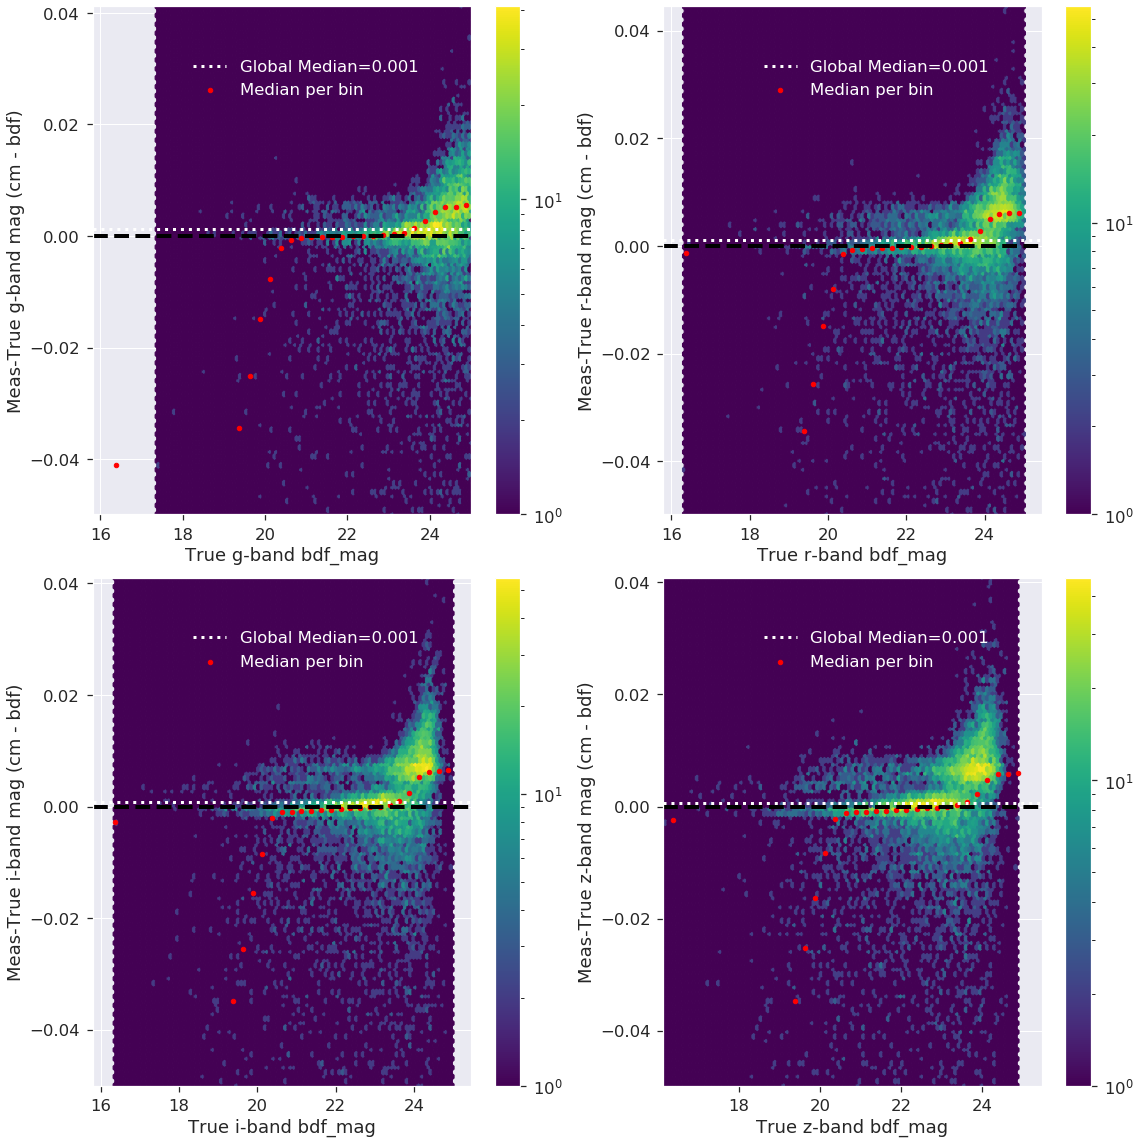

In [11]:
plot_sof_scatter(sample, true_colname='bdf_mag_deredden', meas_colname='meas_cm_mag_deredden',
                 xlim=[16, 25], ylim=[-.05, .05])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


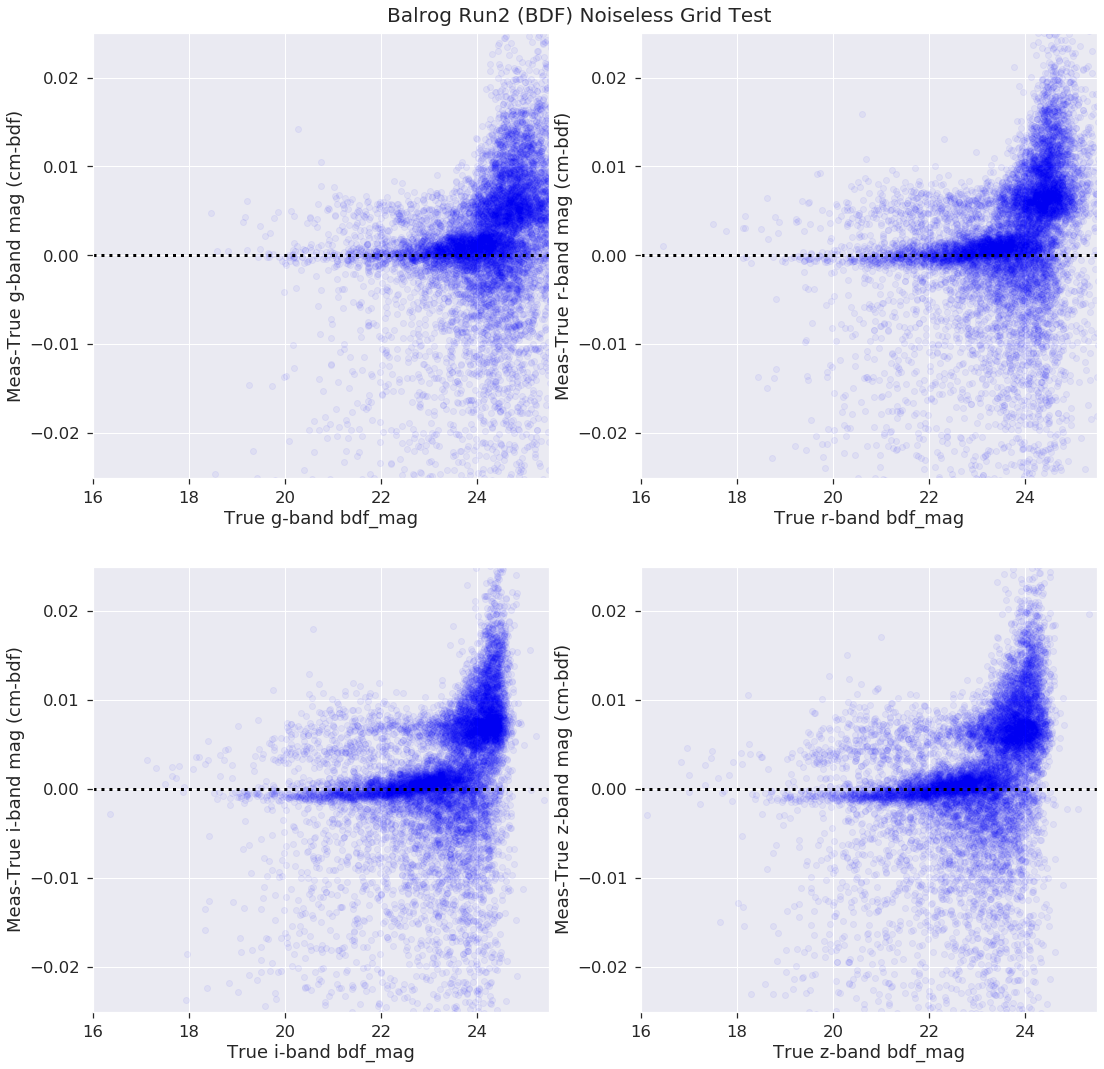

In [12]:
bands = 'griz'
xlim = [16, 25.5]
ylim = [-0.025, 0.025]
alpha = 0.05
# s = sample[~(sample['cm_fracdev'] < 0.95) & (sample['cm_fracdev']>0.01)]
# s = sample[sample['cm_T'] < 0.1]
s = sample
# fd_cut = 0.25
# ltcut = np.where(s['bdf_fracdev'] < fd_cut)
# gtcut = np.where(s['bdf_fracdev'] >= fd_cut)
df = 0.03
df_high = 0.99
bad_cut = np.where( ((s['bdf_fracdev'] > 0.5-df) & (s['bdf_fracdev'] < 0.5+df)) | (s['bdf_fracdev'] > df_high) )
good_cut = np.where( ((s['bdf_fracdev'] <= 0.5-df) | (s['bdf_fracdev'] >= 0.5+df)) & (s['bdf_fracdev'] < df_high))                 
for bi in range(4):
    plt.subplot(2,2,bi+1)
    x = s['bdf_mag_deredden'][:,bi]
    y = s['meas_cm_mag_deredden'][:,bi] - x
#     plt.scatter(x[ltcut], y[ltcut], alpha=alpha, color='b', label='true_fracdev < {}'.format(fd_cut))
#     plt.scatter(x[gtcut], y[gtcut], alpha=alpha, color='g', label='true_fracdev >= {}'.format(fd_cut))
    plt.scatter(x, y, alpha=alpha, color='b')#, label='true_fracdev != {}+/-{} or > {}'.format(0.5, df, df_high))
#     plt.scatter(x[bad_cut], y[bad_cut], alpha=0.75*alpha, color='g', label='true_fracdev == {}+/-{} or > {}'.format(0.5, df, df_high))
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.axhline(0, lw=3, ls=':', c='k')
    plt.xlabel('True {}-band bdf_mag'.format(bands[bi]))
    plt.ylabel('Meas-True {}-band mag (cm-bdf)'.format(bands[bi]))
    plt.legend()
    
plt.suptitle('Balrog Run2 (BDF) Noiseless Grid Test', fontsize=20, y=0.9)
plt.gcf().set_size_inches(18, 18)

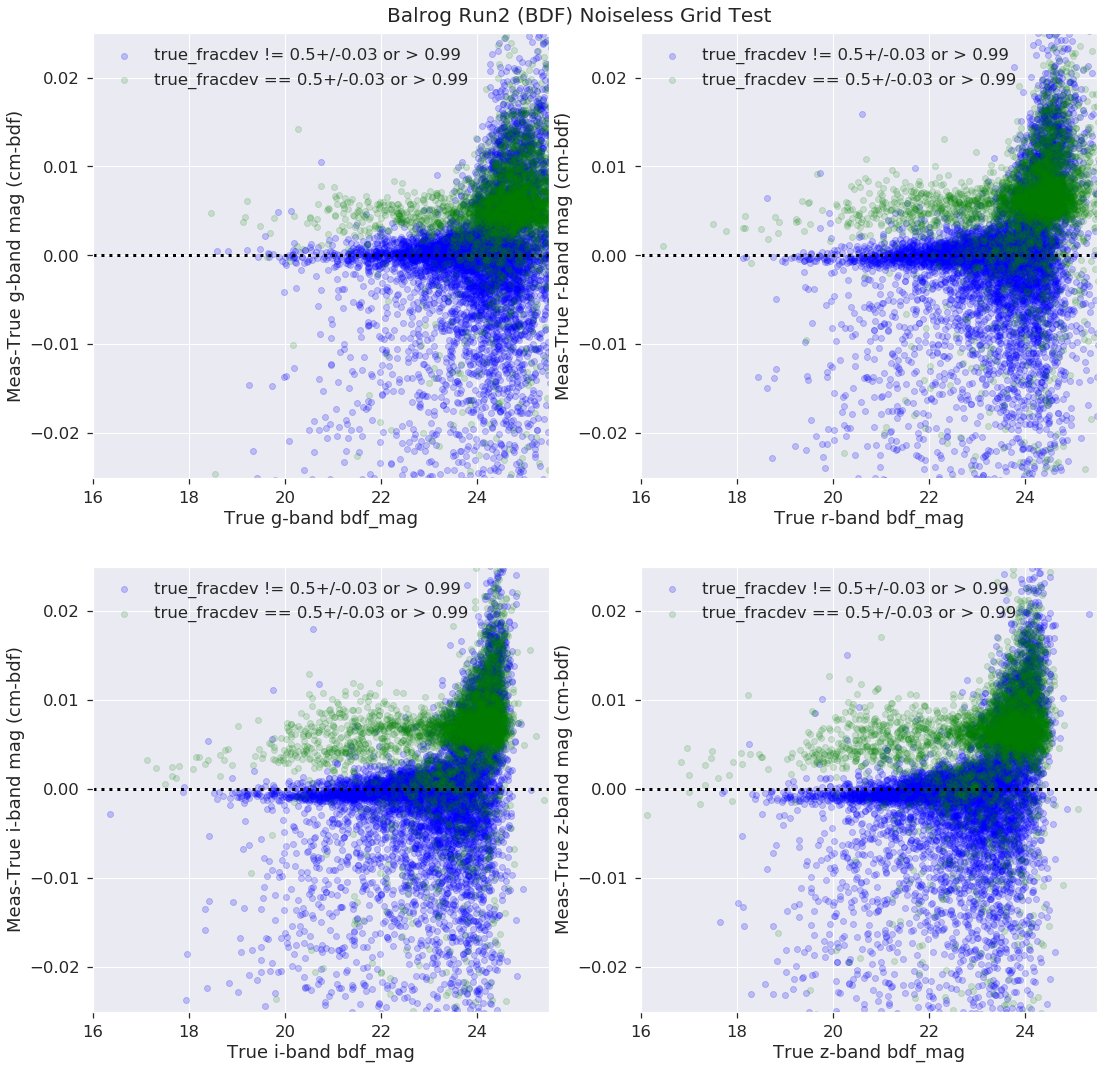

In [13]:
bands = 'griz'
xlim = [16, 25.5]
ylim = [-0.025, 0.025]
alpha = 0.2
# s = sample[~(sample['cm_fracdev'] < 0.95) & (sample['cm_fracdev']>0.01)]
# s = sample[sample['cm_T'] < 0.1]
s = sample
# fd_cut = 0.25
# ltcut = np.where(s['bdf_fracdev'] < fd_cut)
# gtcut = np.where(s['bdf_fracdev'] >= fd_cut)
df = 0.03
df_high = 0.99
bad_cut = np.where( ((s['bdf_fracdev'] > 0.5-df) & (s['bdf_fracdev'] < 0.5+df)) | (s['bdf_fracdev'] > df_high) )
good_cut = np.where( ((s['bdf_fracdev'] <= 0.5-df) | (s['bdf_fracdev'] >= 0.5+df)) & (s['bdf_fracdev'] < df_high))                 
for bi in range(4):
    plt.subplot(2,2,bi+1)
    x = s['bdf_mag_deredden'][:,bi]
    y = s['meas_cm_mag_deredden'][:,bi] - x
#     plt.scatter(x[ltcut], y[ltcut], alpha=alpha, color='b', label='true_fracdev < {}'.format(fd_cut))
#     plt.scatter(x[gtcut], y[gtcut], alpha=alpha, color='g', label='true_fracdev >= {}'.format(fd_cut))
    plt.scatter(x[good_cut], y[good_cut], alpha=alpha, color='b', label='true_fracdev != {}+/-{} or > {}'.format(0.5, df, df_high))
    plt.scatter(x[bad_cut], y[bad_cut], alpha=0.75*alpha, color='g', label='true_fracdev == {}+/-{} or > {}'.format(0.5, df, df_high))
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.axhline(0, lw=3, ls=':', c='k')
    plt.xlabel('True {}-band bdf_mag'.format(bands[bi]))
    plt.ylabel('Meas-True {}-band mag (cm-bdf)'.format(bands[bi]))
    plt.legend()
    
plt.suptitle('Balrog Run2 (BDF) Noiseless Grid Test', fontsize=20, y=0.9)
plt.gcf().set_size_inches(18, 18)

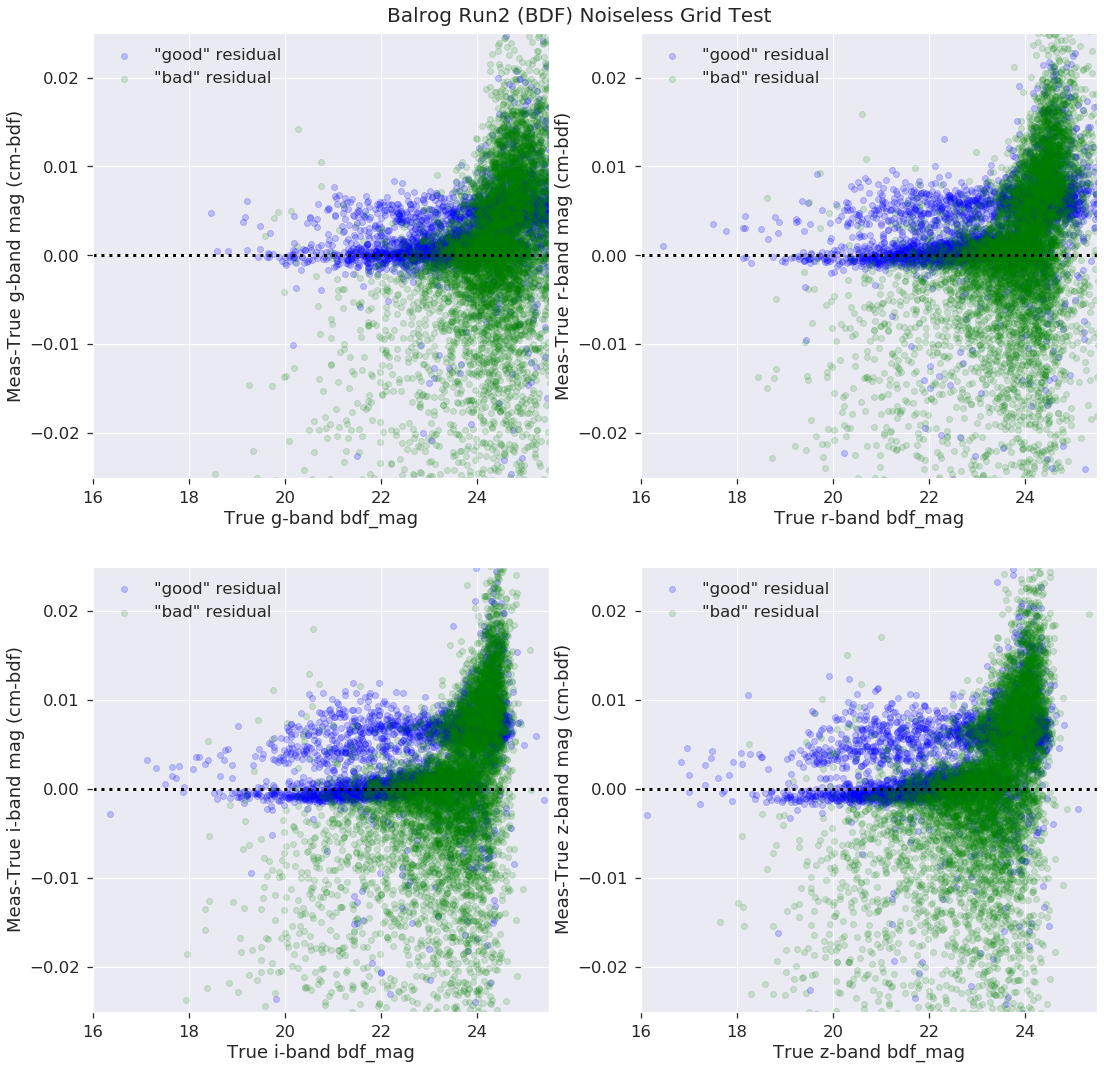

In [14]:
bands = 'griz'
xlim = [16, 25.5]
ylim = [-0.025, 0.025]
alpha = 0.2
# s = sample[~(sample['cm_fracdev'] < 0.95) & (sample['cm_fracdev']>0.01)]
# s = sample[sample['cm_T'] < 0.1]
s = sample
# fd_cut = 0.25
# ltcut = np.where(s['bdf_fracdev'] < fd_cut)
# gtcut = np.where(s['bdf_fracdev'] >= fd_cut)
df_bottom = 0.01
df_high = 0.99
df = 0.01
bad_rs_cut = np.where( ((s['bdf_fracdev'] > df_bottom) & (s['bdf_fracdev'] < 0.5-df)) | ((s['bdf_fracdev'] > 0.5+df) & (s['bdf_fracdev'] < df_high)) )
good_rs_cut = np.where( (s['bdf_fracdev'] <= df_bottom) | ((s['bdf_fracdev'] >= 0.5-df) & (s['bdf_fracdev'] <= 0.5+df)) | (s['bdf_fracdev'] >= df_high) )                 
for bi in range(4):
    plt.subplot(2,2,bi+1)
    x = s['bdf_mag_deredden'][:,bi]
    y = s['meas_cm_mag_deredden'][:,bi] - x
#     plt.scatter(x[ltcut], y[ltcut], alpha=alpha, color='b', label='true_fracdev < {}'.format(fd_cut))
#     plt.scatter(x[gtcut], y[gtcut], alpha=alpha, color='g', label='true_fracdev >= {}'.format(fd_cut))
    plt.scatter(x[good_rs_cut], y[good_rs_cut], alpha=alpha, color='b', label='"good" residual'.format(0.5, df, df_high))
    plt.scatter(x[bad_rs_cut], y[bad_rs_cut], alpha=0.75*alpha, color='g', label='"bad" residual'.format(0.5, df, df_high))
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.axhline(0, lw=3, ls=':', c='k')
    plt.xlabel('True {}-band bdf_mag'.format(bands[bi]))
    plt.ylabel('Meas-True {}-band mag (cm-bdf)'.format(bands[bi]))
    plt.legend()
    
plt.suptitle('Balrog Run2 (BDF) Noiseless Grid Test', fontsize=20, y=0.9)
plt.gcf().set_size_inches(18, 18)

0
1
2
3


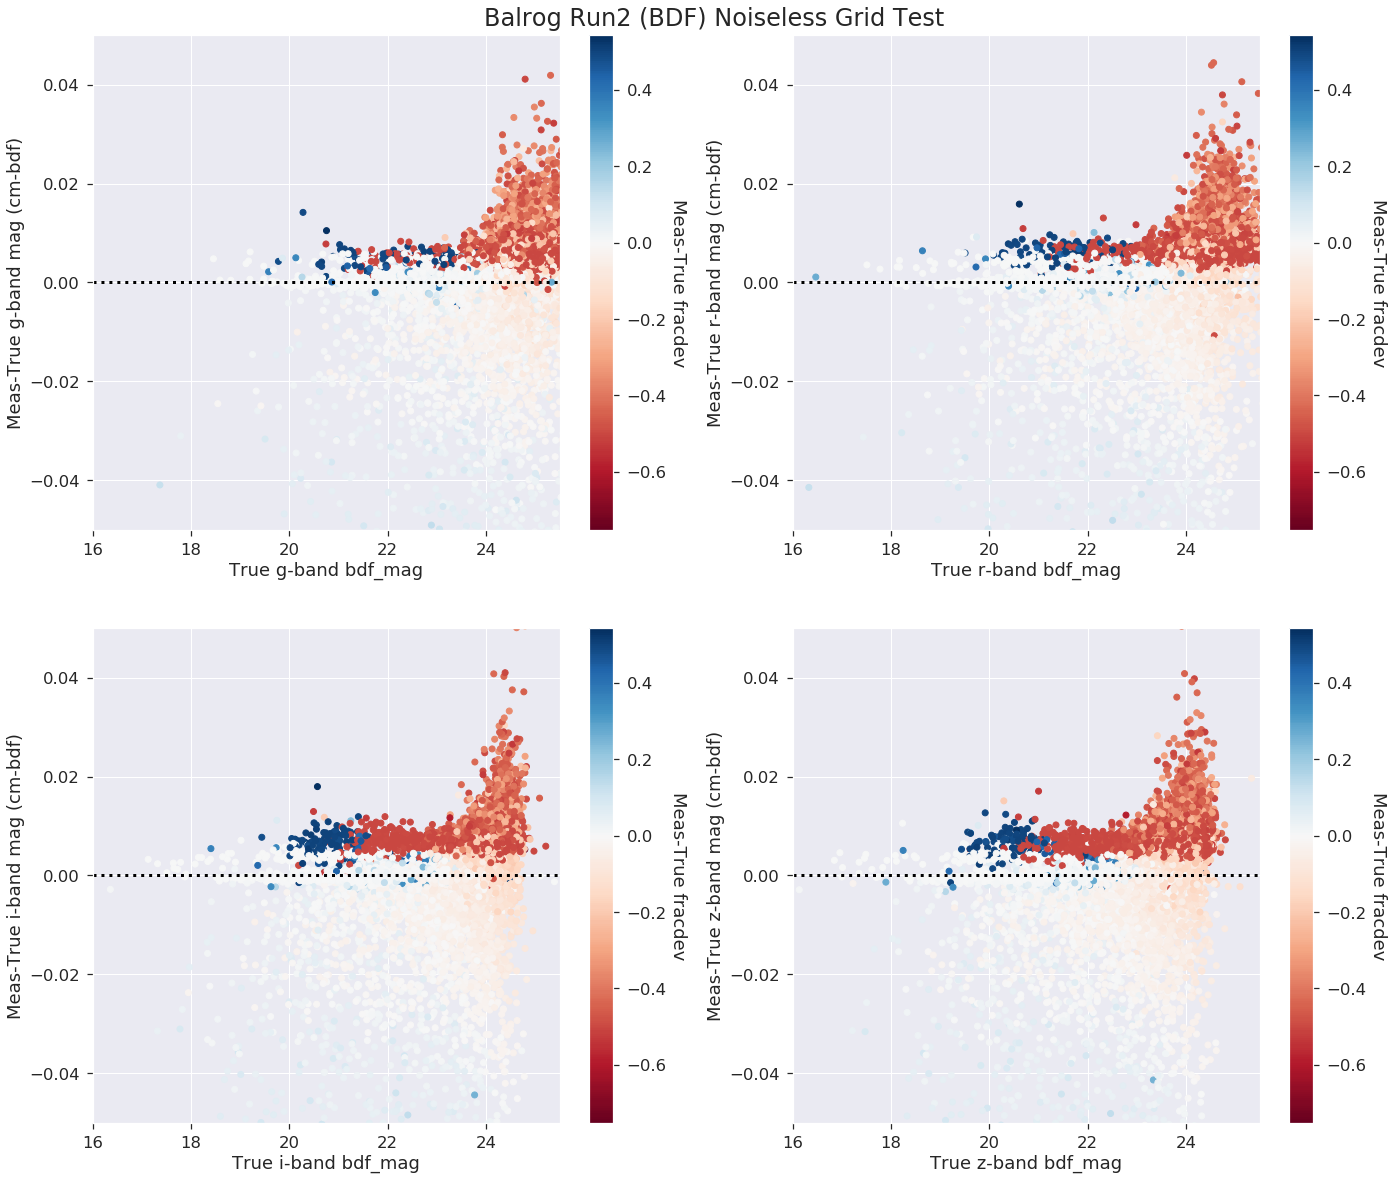

In [15]:
bands = 'griz'
xlim = [16, 25.5]
ylim = [-0.05, 0.05]
alpha = 1
size = 22
s = sample
fd_err = (s['meas_cm_fracdev'] - s['bdf_fracdev'])
cuts = np.where(abs(fd_err) <= 1)
for bi in range(4):
    print(bi)
    plt.subplot(2,2,bi+1)
    x = s['bdf_mag_deredden'][:,bi]
    y = s['meas_cm_mag_deredden'][:,bi] - x
    plt.scatter(x[cuts], y[cuts], alpha=alpha, c=fd_err[cuts], cmap='RdBu', norm=MidpointNormalize(midpoint=0, vmin=min(fd_err[cuts]), vmax=max(fd_err[cuts])))
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.axhline(0, lw=3, ls=':', c='k')
    plt.xlabel('True {}-band bdf_mag'.format(bands[bi]))
    plt.ylabel('Meas-True {}-band mag (cm-bdf)'.format(bands[bi]))
    cbar = plt.colorbar()
    cbar.set_label('Meas-True fracdev', rotation=270, labelpad=20)
    
plt.suptitle('Balrog Run2 (BDF) Noiseless Grid Test', fontsize=24, y=0.9)
plt.gcf().set_size_inches(23, 20)

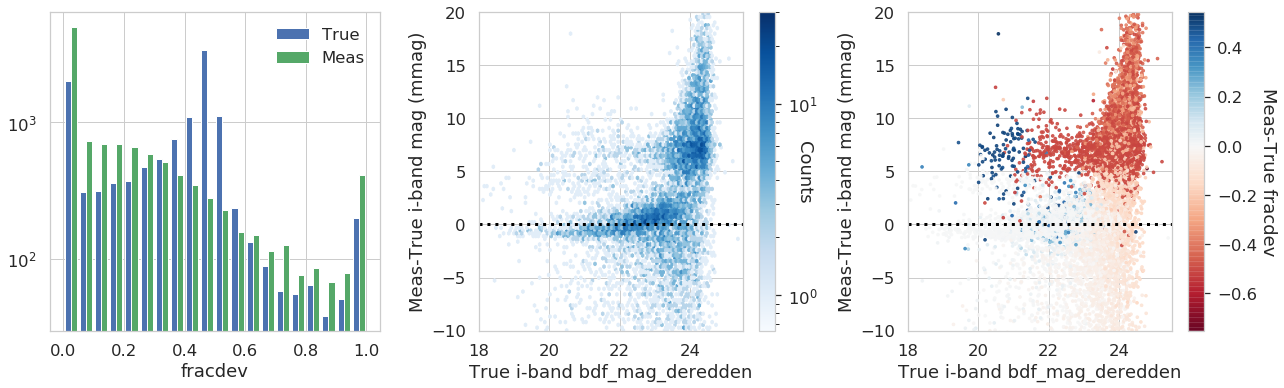

In [13]:
sb.set_style('whitegrid')

band, bi  = 'i', 2

s = sample

# First a histogram comparison

plt.subplot(1, 3, 1)

dx = 0.05
bins = np.arange(0, 1+dx, dx)
# plt.hist(s['bdf_fracdev'], bins=bins, histtype='step', label='True bdf_fracdev', lw=3)
# plt.hist(s['meas_cm_fracdev'], bins=bins, histtype='step', label='Meas cm_fracdev', lw=3)
plt.hist([s['bdf_fracdev'], s['meas_cm_fracdev']], label=['True', 'Meas'], bins=bins)
plt.xlabel('fracdev')
# plt.ylabel('Counts')
plt.legend()
plt.yscale('log')

# Now scatter plots

xlim = [18, 25.5]
ylim = [-10, 20]

fd_err = (s['meas_cm_fracdev'] - s['bdf_fracdev'])

x = s['bdf_mag_deredden'][:,bi]
y = 1000. * (s['meas_cm_mag_deredden'][:,bi] - x)

plt.subplot(1, 3, 2)

dd = 0.001
cuts = np.where( (x >= xlim[0]-dd) & (x < xlim[1]+dd) &
                 (y >= ylim[0]-dd) & (y < ylim[1]+dd) )

plt.hexbin(x[cuts], y[cuts], gridsize=100, cmap='Blues', mincnt=1, norm=colors.LogNorm())
plt.axhline(0, lw=3, ls=':', c='k')
cbar = plt.colorbar()
plt.clim(.65, 30)
cbar.set_label('Counts', rotation=270, labelpad=-5)
plt.xlabel('True {}-band bdf_mag_deredden'.format(band))
plt.ylabel('Meas-True {}-band mag (mmag)'.format(band))

plt.xlim(xlim)
plt.ylim(ylim)

plt.subplot(1, 3, 3)

alpha = 0.85

cuts = np.where(abs(fd_err) <= 1)

plt.scatter(x[cuts], y[cuts], alpha=alpha, c=fd_err[cuts], s=7, cmap='RdBu',
            norm=MidpointNormalize(midpoint=0,vmin=min(fd_err[cuts]), vmax=max(fd_err[cuts])))
plt.xlim(xlim)
plt.ylim(ylim)
plt.axhline(0, lw=3, ls=':', c='k')
plt.xlabel('True {}-band bdf_mag_deredden'.format(band))
plt.ylabel('Meas-True {}-band mag (mmag)'.format(band))
cbar = plt.colorbar()
cbar.set_label('Meas-True fracdev', rotation=270, labelpad=20)
    
# plt.suptitle('Balrog Run2 (BDF) Noiseless Grid Test', fontsize=24, y=0.9)
plt.gcf().set_size_inches(18, 5.5)
plt.tight_layout()

plt.rcParams.update({'font.size': 26})

plt.subplots_adjust(wspace=0.3)

# plt.gcf().savefig('./figs/gridtest-plots.pdf', bbox_inches='tight')

plot 1
plot 2
plot 3
plot 4


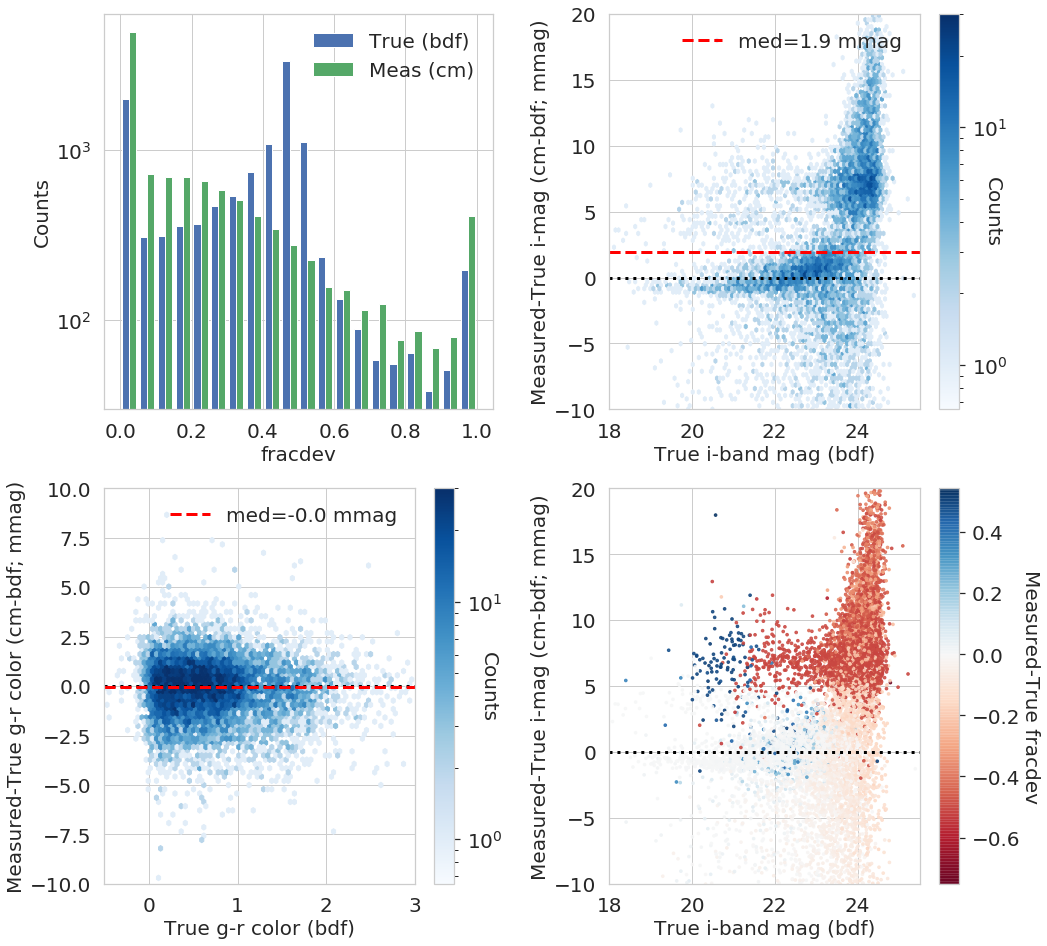

In [15]:
sb.set_style('whitegrid')

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

band, bi  = 'i', 2

s = sample

# First a histogram comparison

print('plot 1')
plt.subplot(2, 2, 1)

dx = 0.05
bins = np.arange(0, 1+dx, dx)
# plt.hist(s['bdf_fracdev'], bins=bins, histtype='step', label='True bdf_fracdev', lw=3)
# plt.hist(s['meas_cm_fracdev'], bins=bins, histtype='step', label='Meas cm_fracdev', lw=3)
plt.hist([s['bdf_fracdev'], s['meas_cm_fracdev']], label=['True (bdf)', 'Meas (cm)'], bins=bins)
plt.xlabel('fracdev')
plt.ylabel('Counts')
plt.legend()
plt.yscale('log')

# Now scatter plots

xlim = [18, 25.5]
ylim = [-10, 20]

fd_err = (s['meas_cm_fracdev'] - s['bdf_fracdev'])

x = s['bdf_mag_deredden'][:,bi]
y = 1000. * (s['meas_cm_mag_deredden'][:,bi] - x)

print('plot 2')
plt.subplot(2, 2, 2)

dd = 0.001
cuts = np.where( (x >= xlim[0]-dd) & (x < xlim[1]+dd) &
                 (y >= ylim[0]-dd) & (y < ylim[1]+dd) )

plt.hexbin(x[cuts], y[cuts], gridsize=100, cmap='Blues', mincnt=1, norm=colors.LogNorm())
med = np.median(y[cuts])
plt.axhline(med, lw=3, ls='--', c='r', label=f'med={med:.1f} mmag')
plt.axhline(0, lw=3, ls=':', c='k')
cbar = plt.colorbar()
plt.clim(.65, 30)
cbar.set_label('Counts', rotation=270, labelpad=-5)
plt.xlabel('True {}-band mag (bdf)'.format(band))
plt.ylabel('Measured-True {}-mag (cm-bdf; mmag)'.format(band))

plt.xlim(xlim)
plt.ylim(ylim)

plt.legend()

print('plot 3')
plt.subplot(2, 2, 4)

alpha = 0.85

cuts = np.where(abs(fd_err) <= 1)

plt.scatter(x[cuts], y[cuts], alpha=alpha, c=fd_err[cuts], s=7, cmap='RdBu',
            norm=MidpointNormalize(midpoint=0,vmin=min(fd_err[cuts]), vmax=max(fd_err[cuts])))
plt.xlim(xlim)
plt.ylim(ylim)
plt.axhline(0, lw=3, ls=':', c='k')
plt.xlabel('True {}-band mag (bdf)'.format(band))
plt.ylabel('Measured-True {}-mag (cm-bdf; mmag)'.format(band))
cbar = plt.colorbar()
cbar.set_label('Measured-True fracdev', rotation=270, labelpad=20)

# Now color

print('plot 4')
plt.subplot(2, 2, 3)

xlim = [-.5, 3]
ylim = [-10, 10]

b1, b2 = 'g', 'r'
b1i, b2i = 0, 1

x = s['bdf_mag_deredden'][:,b1i] - s['bdf_mag_deredden'][:,b2i] 
y = 1000. * ( (s['meas_cm_mag_deredden'][:,b1i] - s['meas_cm_mag_deredden'][:,b2i]) - x)

dd = 0.001
cuts = np.where( (x >= xlim[0]-dd) & (x < xlim[1]+dd) &
                 (y >= ylim[0]-dd) & (y < ylim[1]+dd) )

plt.hexbin(x[cuts], y[cuts], gridsize=75, cmap='Blues', mincnt=1, norm=colors.LogNorm())
med = np.median(y[cuts])
plt.axhline(0, lw=3, ls=':', c='k')
plt.axhline(med, lw=3, ls='--', c='r', label=f'med={med:.1f} mmag')
cbar = plt.colorbar()
plt.clim(.65, 30)
cbar.set_label('Counts', rotation=270, labelpad=-5)
plt.xlabel(f'True {b1}-{b2} color (bdf)')
plt.ylabel(f'Measured-True {b1}-{b2} color (cm-bdf; mmag)')

plt.xlim(xlim)
plt.ylim(ylim)

plt.legend()

# plt.suptitle('Balrog Run2 (BDF) Noiseless Grid Test', fontsize=24, y=0.9)
plt.gcf().set_size_inches(16, 16)
# plt.tight_layout()

plt.rcParams.update({'font.size': 26})

plt.subplots_adjust(wspace=0.3)

plt.gcf().savefig('./figs/gridtest-plots-4.pdf', bbox_inches='tight')

plot 1


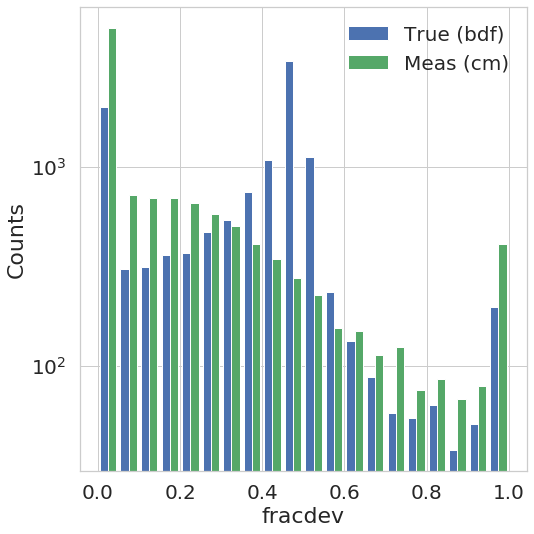

plot 2


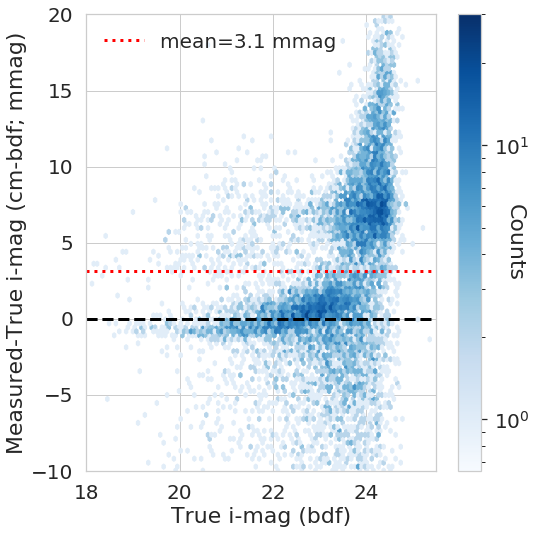

plot 3


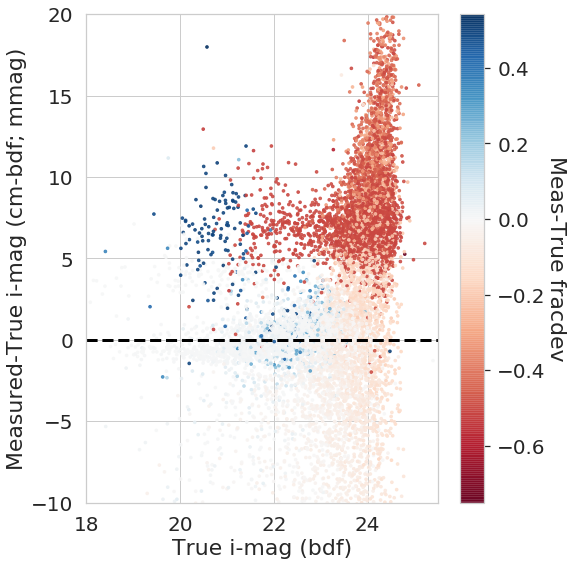

plot 4


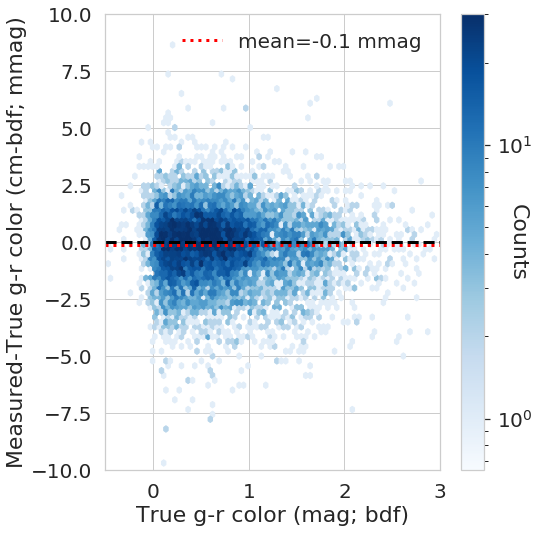

In [30]:
sb.set_style('whitegrid')

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

band, bi  = 'i', 2

s = sample

ss = 8

# First a histogram comparison

print('plot 1')
# plt.subplot(2, 2, 1)

dx = 0.05
bins = np.arange(0, 1+dx, dx)
# plt.hist(s['bdf_fracdev'], bins=bins, histtype='step', label='True bdf_fracdev', lw=3)
# plt.hist(s['meas_cm_fracdev'], bins=bins, histtype='step', label='Meas cm_fracdev', lw=3)
plt.hist([s['bdf_fracdev'], s['meas_cm_fracdev']], label=['True (bdf)', 'Meas (cm)'], bins=bins)
plt.xlabel('fracdev')
plt.ylabel('Counts')
plt.legend()
plt.yscale('log')

plt.gcf().set_size_inches(ss, ss)
plt.rcParams.update({'font.size': 26})
plt.tight_layout()
plt.gcf().savefig('./figs/gridtest-plots-4-1.pdf', bbox_inches='tight')
plt.show()

# Now scatter plots

xlim = [18, 25.5]
ylim = [-10, 20]

fd_err = (s['meas_cm_fracdev'] - s['bdf_fracdev'])

x = s['bdf_mag_deredden'][:,bi]
y = 1000. * (s['meas_cm_mag_deredden'][:,bi] - x)

print('plot 2')
# plt.subplot(2, 2, 2)

dd = 0.001
cuts = np.where( (x >= xlim[0]-dd) & (x < xlim[1]+dd) &
                 (y >= ylim[0]-dd) & (y < ylim[1]+dd) )

plt.hexbin(x[cuts], y[cuts], gridsize=100, cmap='Blues', mincnt=1, norm=colors.LogNorm())
med = np.median(y[cuts])
mean = np.mean(y[cuts])
plt.axhline(mean, lw=3, ls=':', c='r', label=f'mean={mean:.1f} mmag')
# plt.axhline(med, lw=3, ls='--', c='r', label=f'med={med:.1f} mmag')
plt.axhline(0, lw=3, ls='--', c='k')
cbar = plt.colorbar()
plt.clim(.65, 30)
cbar.set_label('Counts', rotation=270, labelpad=-5)
plt.xlabel('True {}-mag (bdf)'.format(band))
plt.ylabel('Measured-True {}-mag (cm-bdf; mmag)'.format(band))

plt.xlim(xlim)
plt.ylim(ylim)

plt.legend(loc='upper left')

plt.gcf().set_size_inches(ss, ss)
plt.rcParams.update({'font.size': 26})
plt.tight_layout()
plt.gcf().savefig('./figs/gridtest-plots-4-2.pdf', bbox_inches='tight')
plt.show()

print('plot 3')
# plt.subplot(2, 2, 4)

alpha = 0.85

cuts = np.where(abs(fd_err) <= 1)

plt.scatter(x[cuts], y[cuts], alpha=alpha, c=fd_err[cuts], s=7, cmap='RdBu',
            norm=MidpointNormalize(midpoint=0,vmin=min(fd_err[cuts]), vmax=max(fd_err[cuts])),
            rasterized=True)
plt.xlim(xlim)
plt.ylim(ylim)
plt.axhline(0, lw=3, ls='--', c='k')
plt.xlabel('True {}-mag (bdf)'.format(band))
plt.ylabel('Measured-True {}-mag (cm-bdf; mmag)'.format(band))
cbar = plt.colorbar()
cbar.set_label('Meas-True fracdev', rotation=270, labelpad=20)

plt.gcf().set_size_inches(ss+0.45, ss+0.45)
plt.rcParams.update({'font.size': 26})
plt.tight_layout()
plt.gcf().savefig('./figs/gridtest-plots-4-4.pdf', bbox_inches='tight')
plt.show()

# Now color

print('plot 4')
# plt.subplot(2, 2, 3)

xlim = [-.5, 3]
ylim = [-10, 10]

b1, b2 = 'g', 'r'
b1i, b2i = 0, 1

x = s['bdf_mag_deredden'][:,b1i] - s['bdf_mag_deredden'][:,b2i] 
y = 1000. * ( (s['meas_cm_mag_deredden'][:,b1i] - s['meas_cm_mag_deredden'][:,b2i]) - x)

dd = 0.001
cuts = np.where( (x >= xlim[0]-dd) & (x < xlim[1]+dd) &
                 (y >= ylim[0]-dd) & (y < ylim[1]+dd) )

plt.hexbin(x[cuts], y[cuts], gridsize=75, cmap='Blues', mincnt=1, norm=colors.LogNorm())
med = np.median(y[cuts])
mean = np.mean(y[cuts])
plt.axhline(mean, lw=3, ls=':', c='r', label=f'mean={mean:.1f} mmag')
plt.axhline(0, lw=3, ls='--', c='k')
# plt.axhline(med, lw=3, ls='--', c='r', label=f'med={med:.1f} mmag')
cbar = plt.colorbar()
plt.clim(.65, 30)
cbar.set_label('Counts', rotation=270, labelpad=-5)
plt.xlabel(f'True {b1}-{b2} color (mag; bdf)')
plt.ylabel(f'Measured-True {b1}-{b2} color (cm-bdf; mmag)')

plt.xlim(xlim)
plt.ylim(ylim)

plt.legend()

plt.gcf().set_size_inches(ss, ss)
plt.rcParams.update({'font.size': 26})
plt.tight_layout()
plt.gcf().savefig('./figs/gridtest-plots-4-3.pdf', bbox_inches='tight')
plt.show()

plot 1


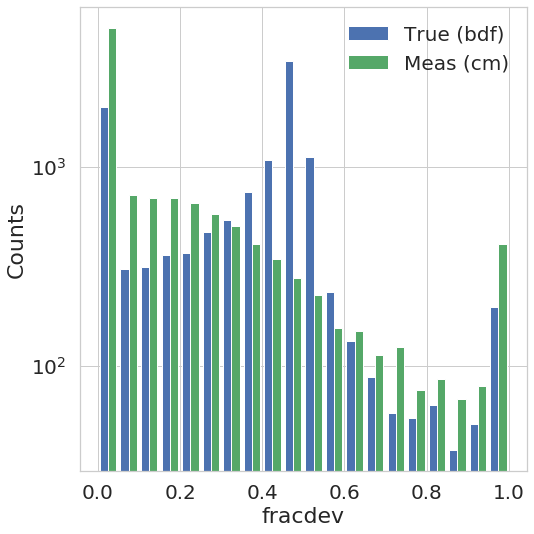

plot 2


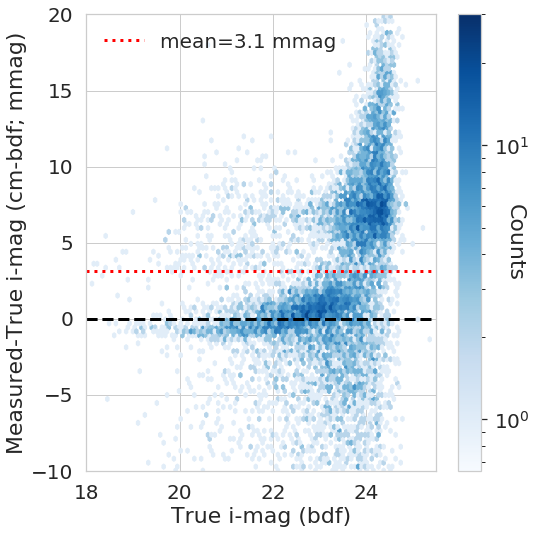

plot 3


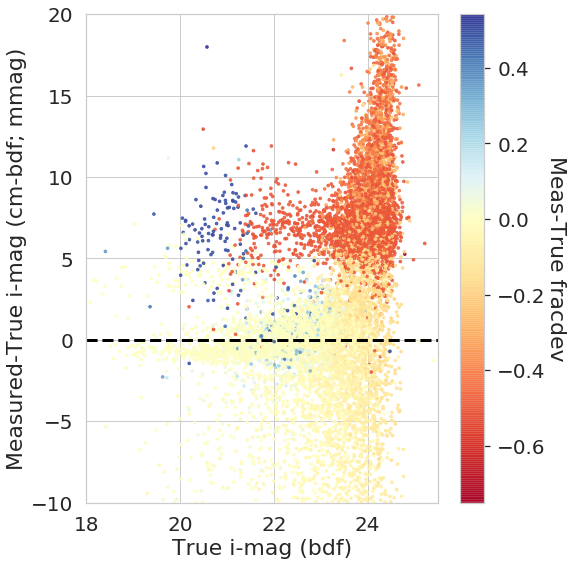

plot 4


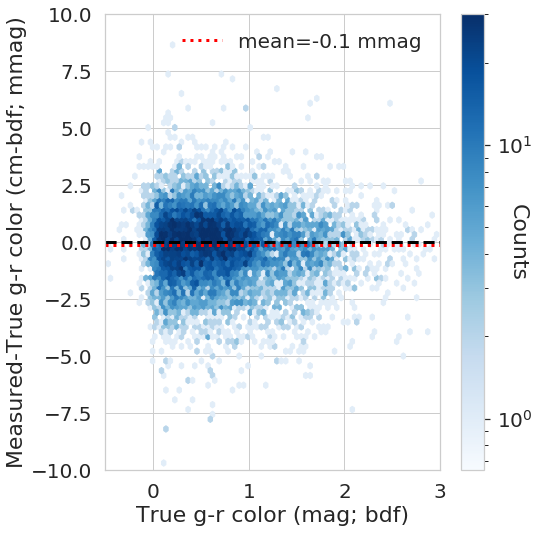

In [19]:
## An extra version of the above plotting script just to play around with color schemes for the paper revision

sb.set_style('whitegrid')

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

band, bi  = 'i', 2

s = sample

ss = 8

# First a histogram comparison

print('plot 1')
# plt.subplot(2, 2, 1)

dx = 0.05
bins = np.arange(0, 1+dx, dx)
# plt.hist(s['bdf_fracdev'], bins=bins, histtype='step', label='True bdf_fracdev', lw=3)
# plt.hist(s['meas_cm_fracdev'], bins=bins, histtype='step', label='Meas cm_fracdev', lw=3)
plt.hist([s['bdf_fracdev'], s['meas_cm_fracdev']], label=['True (bdf)', 'Meas (cm)'], bins=bins)
plt.xlabel('fracdev')
plt.ylabel('Counts')
plt.legend()
plt.yscale('log')

plt.gcf().set_size_inches(ss, ss)
plt.rcParams.update({'font.size': 26})
plt.tight_layout()
plt.gcf().savefig('./figs/gridtest-plots-4-1.pdf', bbox_inches='tight')
plt.show()

# Now scatter plots

xlim = [18, 25.5]
ylim = [-10, 20]

fd_err = (s['meas_cm_fracdev'] - s['bdf_fracdev'])

x = s['bdf_mag_deredden'][:,bi]
y = 1000. * (s['meas_cm_mag_deredden'][:,bi] - x)

print('plot 2')
# plt.subplot(2, 2, 2)

dd = 0.001
cuts = np.where( (x >= xlim[0]-dd) & (x < xlim[1]+dd) &
                 (y >= ylim[0]-dd) & (y < ylim[1]+dd) )

plt.hexbin(x[cuts], y[cuts], gridsize=100, cmap='Blues', mincnt=1, norm=colors.LogNorm())
med = np.median(y[cuts])
mean = np.mean(y[cuts])
plt.axhline(mean, lw=3, ls=':', c='r', label=f'mean={mean:.1f} mmag')
# plt.axhline(med, lw=3, ls='--', c='r', label=f'med={med:.1f} mmag')
plt.axhline(0, lw=3, ls='--', c='k')
cbar = plt.colorbar()
plt.clim(.65, 30)
cbar.set_label('Counts', rotation=270, labelpad=-5)
plt.xlabel('True {}-mag (bdf)'.format(band))
plt.ylabel('Measured-True {}-mag (cm-bdf; mmag)'.format(band))

plt.xlim(xlim)
plt.ylim(ylim)

plt.legend(loc='upper left')

plt.gcf().set_size_inches(ss, ss)
plt.rcParams.update({'font.size': 26})
plt.tight_layout()
plt.gcf().savefig('./figs/gridtest-plots-4-2.pdf', bbox_inches='tight')
plt.show()

print('plot 3')
# plt.subplot(2, 2, 4)

alpha = 0.85

cuts = np.where(abs(fd_err) <= 1)

plt.scatter(x[cuts], y[cuts], alpha=alpha, c=fd_err[cuts], s=7, cmap='RdYlBu',
            norm=MidpointNormalize(midpoint=0,vmin=min(fd_err[cuts]), vmax=max(fd_err[cuts])),
            rasterized=True)
plt.xlim(xlim)
plt.ylim(ylim)
plt.axhline(0, lw=3, ls='--', c='k')
plt.xlabel('True {}-mag (bdf)'.format(band))
plt.ylabel('Measured-True {}-mag (cm-bdf; mmag)'.format(band))
cbar = plt.colorbar()
cbar.set_label('Meas-True fracdev', rotation=270, labelpad=20)

plt.gcf().set_size_inches(ss+0.45, ss+0.45)
plt.rcParams.update({'font.size': 26})
plt.tight_layout()
plt.gcf().savefig('./figs/gridtest-plots-4-4.pdf', bbox_inches='tight')
plt.show()

# Now color

print('plot 4')
# plt.subplot(2, 2, 3)

xlim = [-.5, 3]
ylim = [-10, 10]

b1, b2 = 'g', 'r'
b1i, b2i = 0, 1

x = s['bdf_mag_deredden'][:,b1i] - s['bdf_mag_deredden'][:,b2i] 
y = 1000. * ( (s['meas_cm_mag_deredden'][:,b1i] - s['meas_cm_mag_deredden'][:,b2i]) - x)

dd = 0.001
cuts = np.where( (x >= xlim[0]-dd) & (x < xlim[1]+dd) &
                 (y >= ylim[0]-dd) & (y < ylim[1]+dd) )

plt.hexbin(x[cuts], y[cuts], gridsize=75, cmap='Blues', mincnt=1, norm=colors.LogNorm())
med = np.median(y[cuts])
mean = np.mean(y[cuts])
plt.axhline(mean, lw=3, ls=':', c='r', label=f'mean={mean:.1f} mmag')
plt.axhline(0, lw=3, ls='--', c='k')
# plt.axhline(med, lw=3, ls='--', c='r', label=f'med={med:.1f} mmag')
cbar = plt.colorbar()
plt.clim(.65, 30)
cbar.set_label('Counts', rotation=270, labelpad=-5)
plt.xlabel(f'True {b1}-{b2} color (mag; bdf)')
plt.ylabel(f'Measured-True {b1}-{b2} color (cm-bdf; mmag)')

plt.xlim(xlim)
plt.ylim(ylim)

plt.legend()

plt.gcf().set_size_inches(ss, ss)
plt.rcParams.update({'font.size': 26})
plt.tight_layout()
plt.gcf().savefig('./figs/gridtest-plots-4-3.pdf', bbox_inches='tight')
plt.show()

In [27]:
ls figs/

ambiguous-matching-panels.pdf           grid-gals-color-response.pdf
balrog-gals-color-response-resize.pdf   gridtest-mag-response.pdf
balrog-gals-color-response.pdf          gridtest-plots-4-1.pdf
balrog-gals-mag-response.pdf            gridtest-plots-4-2.pdf
balrog-stars-color-response-resize.pdf  gridtest-plots-4-3.pdf
balrog-stars-color-response.pdf         gridtest-plots-4-4.pdf
balrog-stars-mag-response.pdf           gridtest-plots-4.pdf
delta-ga-color-color.pdf                gridtest-plots.pdf
delta-gal-color-color.png               injs-per-object.pdf
delta-star-color-color-100-1.pdf        mag-response-by-T-25.pdf
delta-star-color-color-100-1.png        mag-response-by-T-25.png
delta-star-color-color-100-4iso.pdf     mag-response-by-T-33.png
delta-star-color-color-100-4iso.png     mag-response-by-T-50.png
delta-star-color-color.pdf              mag-response-by-T.pdf
delta-star-color-color.png              mag-response-by-T.png
gal-mag-response-outliers.pdf           stars-mea

0
1
2


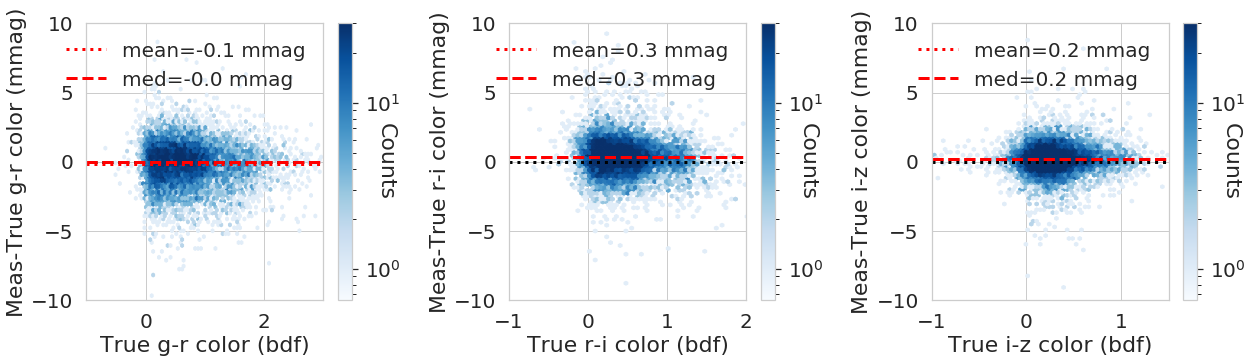

In [35]:
sb.set_style('whitegrid')

s = sample
xlim = [-1, 3]
ylim = [-10, 10]

k = 0
for b1, b2 in zip('gri', 'riz'):
    print(k)
    b1i, b2i = k, k+1

    x = s['bdf_mag_deredden'][:,b1i] - s['bdf_mag_deredden'][:,b2i] 
    y = 1000. * ( (s['meas_cm_mag_deredden'][:,b1i] - s['meas_cm_mag_deredden'][:,b2i]) - x)

    plt.subplot(1, 3, k+1)

    dd = 0.001
    cuts = np.where( (x >= xlim[0]-dd) & (x < xlim[1]+dd) &
                     (y >= ylim[0]-dd) & (y < ylim[1]+dd) )

    plt.hexbin(x[cuts], y[cuts], gridsize=75, cmap='Blues', mincnt=1, norm=colors.LogNorm())
    med = np.median(y[cuts])
    mean = np.mean(y[cuts])
    plt.axhline(mean, lw=3, ls=':', c='r', label=f'mean={mean:.1f} mmag')
    plt.axhline(0, lw=3, ls=':', c='k')
    plt.axhline(med, lw=3, ls='--', c='r', label=f'med={med:.1f} mmag')
    cbar = plt.colorbar()
    plt.clim(.65, 30)
    cbar.set_label('Counts', rotation=270, labelpad=-5)
    plt.xlabel(f'True {b1}-{b2} color (bdf)')
    plt.ylabel(f'Meas-True {b1}-{b2} color (mmag)')
    
    xlim = [-1, 3-1*k]
    
    if k == 2:
        xlim = [-1, 1.5]

    plt.xlim(xlim)
    plt.ylim(ylim)
    
    plt.legend()
                
    k += 1


plt.gcf().set_size_inches(18, 5.5)
plt.tight_layout()

plt.rcParams.update({'font.size': 26})

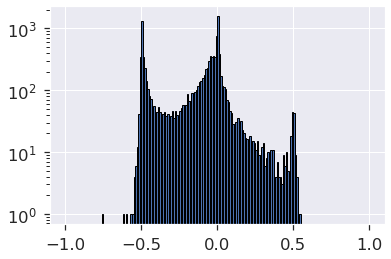

In [38]:
bins=np.arange(-1,1+.01, .01)
plt.hist(fd_err, bins=bins, ec='k')
plt.yscale('log')

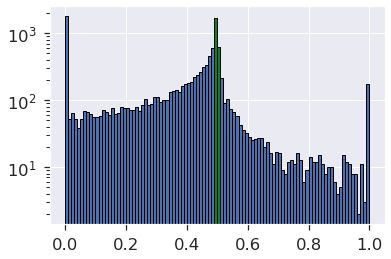

In [33]:
bins=np.arange(0,1+.01, .01)
plt.hist(sample['bdf_fracdev'], bins=bins, ec='k')
plt.hist(sample[(sample['bdf_fracdev']<0.5+df) & (sample['bdf_fracdev']>0.5-df)]['bdf_fracdev'], bins=bins, ec='k', alpha=0.7, color='g')
plt.yscale('log')

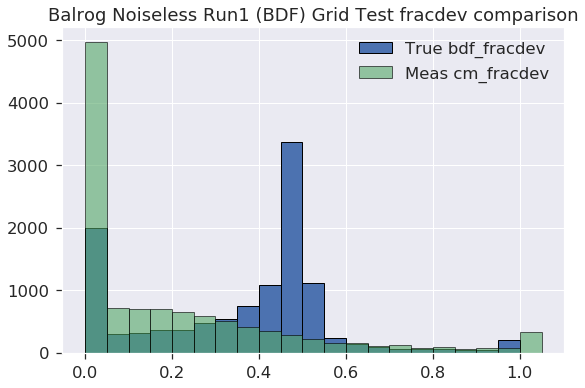

In [39]:
df = 0.05
bins = np.arange(0, 1+2*df, df)
plt.hist(sample['bdf_fracdev'], bins=bins, ec='k', label='True bdf_fracdev')
plt.hist(sample['meas_cm_fracdev'], bins=bins, ec='k', label='Meas cm_fracdev', alpha=0.6)
plt.legend()
plt.title('Balrog Noiseless Run1 (BDF) Grid Test fracdev comparison')
plt.gcf().set_size_inches(9,6)
# plt.yscale('log')

# Run1 Noiseless Grid Test (CM)

In [94]:
run_name = 'noiseless-grid-test-cm-no-sn-redo'
tile = 'DES0347-5540'

In [95]:
true, meas = grab_cats(run_name, tile, true_profile='cm', ext_true_cols=['cm_T'])

Ntrue: 11617
Nmeas: 14477


In [96]:
sample = match(true, meas)

len before: 11617
len after: 11568


g
r
i
z


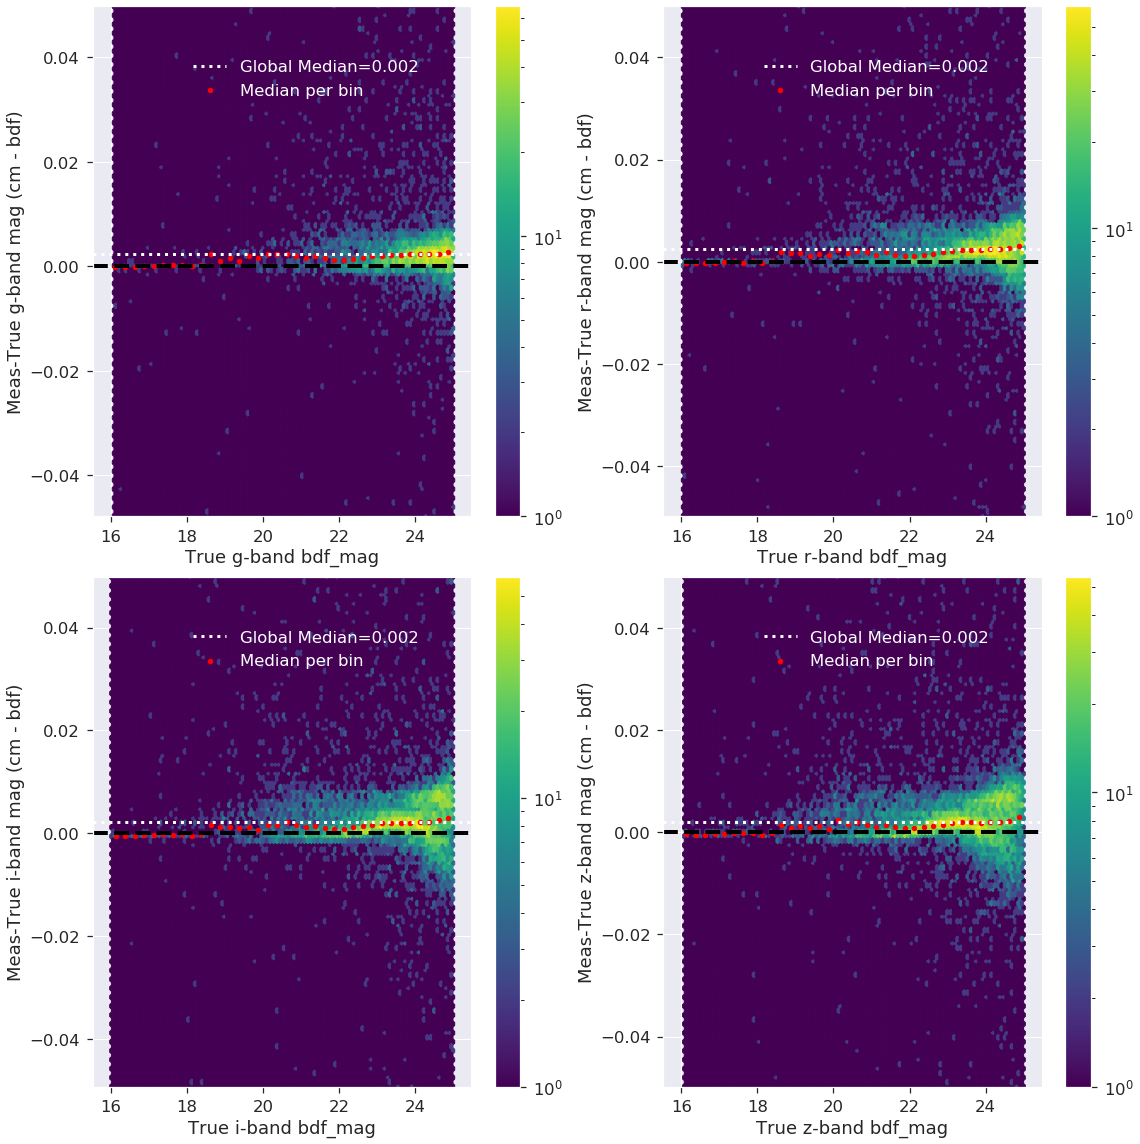

In [97]:
plot_sof_scatter(sample, true_colname='cm_mag_deredden', meas_colname='meas_cm_mag_deredden',
                 xlim=[16, 25], ylim=[-.05, .05])

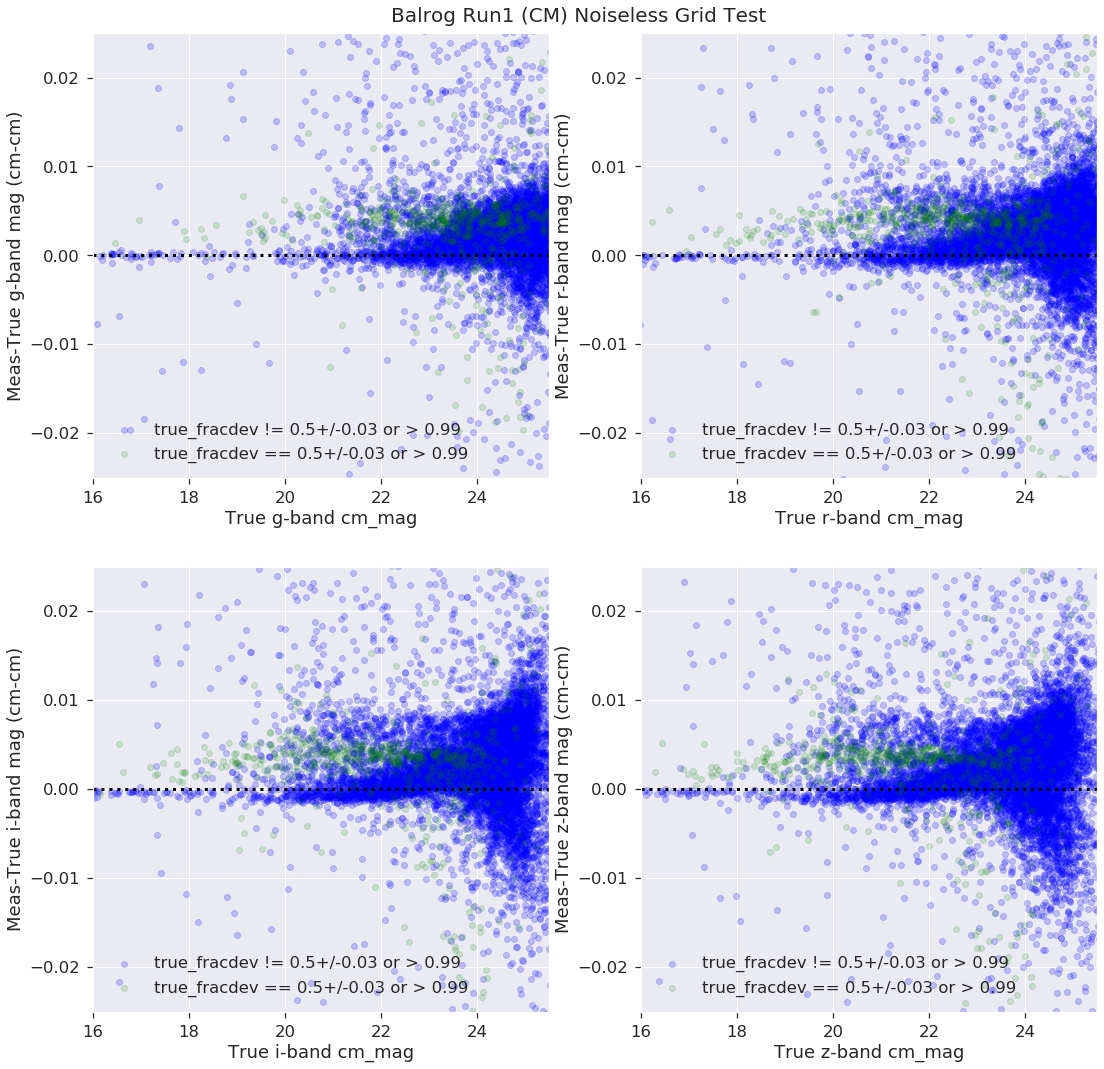

In [98]:
bands = 'griz'
xlim = [16, 25.5]
ylim = [-0.025, 0.025]
alpha = 0.2
# s = sample[~(sample['cm_fracdev'] < 0.95) & (sample['cm_fracdev']>0.01)]
# s = sample[sample['cm_T'] < 0.1]
s = sample
# fd_cut = 0.25
# ltcut = np.where(s['bdf_fracdev'] < fd_cut)
# gtcut = np.where(s['bdf_fracdev'] >= fd_cut)
df = 0.03
df_high = 0.99
bad_cut = np.where( ((s['cm_fracdev'] > 0.5-df) & (s['cm_fracdev'] < 0.5+df)) | (s['cm_fracdev'] > df_high) )
good_cut = np.where( ((s['cm_fracdev'] <= 0.5-df) | (s['cm_fracdev'] >= 0.5+df)) & (s['cm_fracdev'] < df_high))                 
for bi in range(4):
    plt.subplot(2,2,bi+1)
    x = s['cm_mag_deredden'][:,bi]
    y = s['meas_cm_mag_deredden'][:,bi] - x
#     plt.scatter(x[ltcut], y[ltcut], alpha=alpha, color='b', label='true_fracdev < {}'.format(fd_cut))
#     plt.scatter(x[gtcut], y[gtcut], alpha=alpha, color='g', label='true_fracdev >= {}'.format(fd_cut))
    plt.scatter(x[good_cut], y[good_cut], alpha=alpha, color='b', label='true_fracdev != {}+/-{} or > {}'.format(0.5, df, df_high))
    plt.scatter(x[bad_cut], y[bad_cut], alpha=0.75*alpha, color='g', label='true_fracdev == {}+/-{} or > {}'.format(0.5, df, df_high))
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.axhline(0, lw=3, ls=':', c='k')
    plt.xlabel('True {}-band cm_mag'.format(bands[bi]))
    plt.ylabel('Meas-True {}-band mag (cm-cm)'.format(bands[bi]))
    plt.legend()
    
plt.suptitle('Balrog Run1 (CM) Noiseless Grid Test', fontsize=20, y=0.9)
plt.gcf().set_size_inches(18, 18)

0
1
2
3


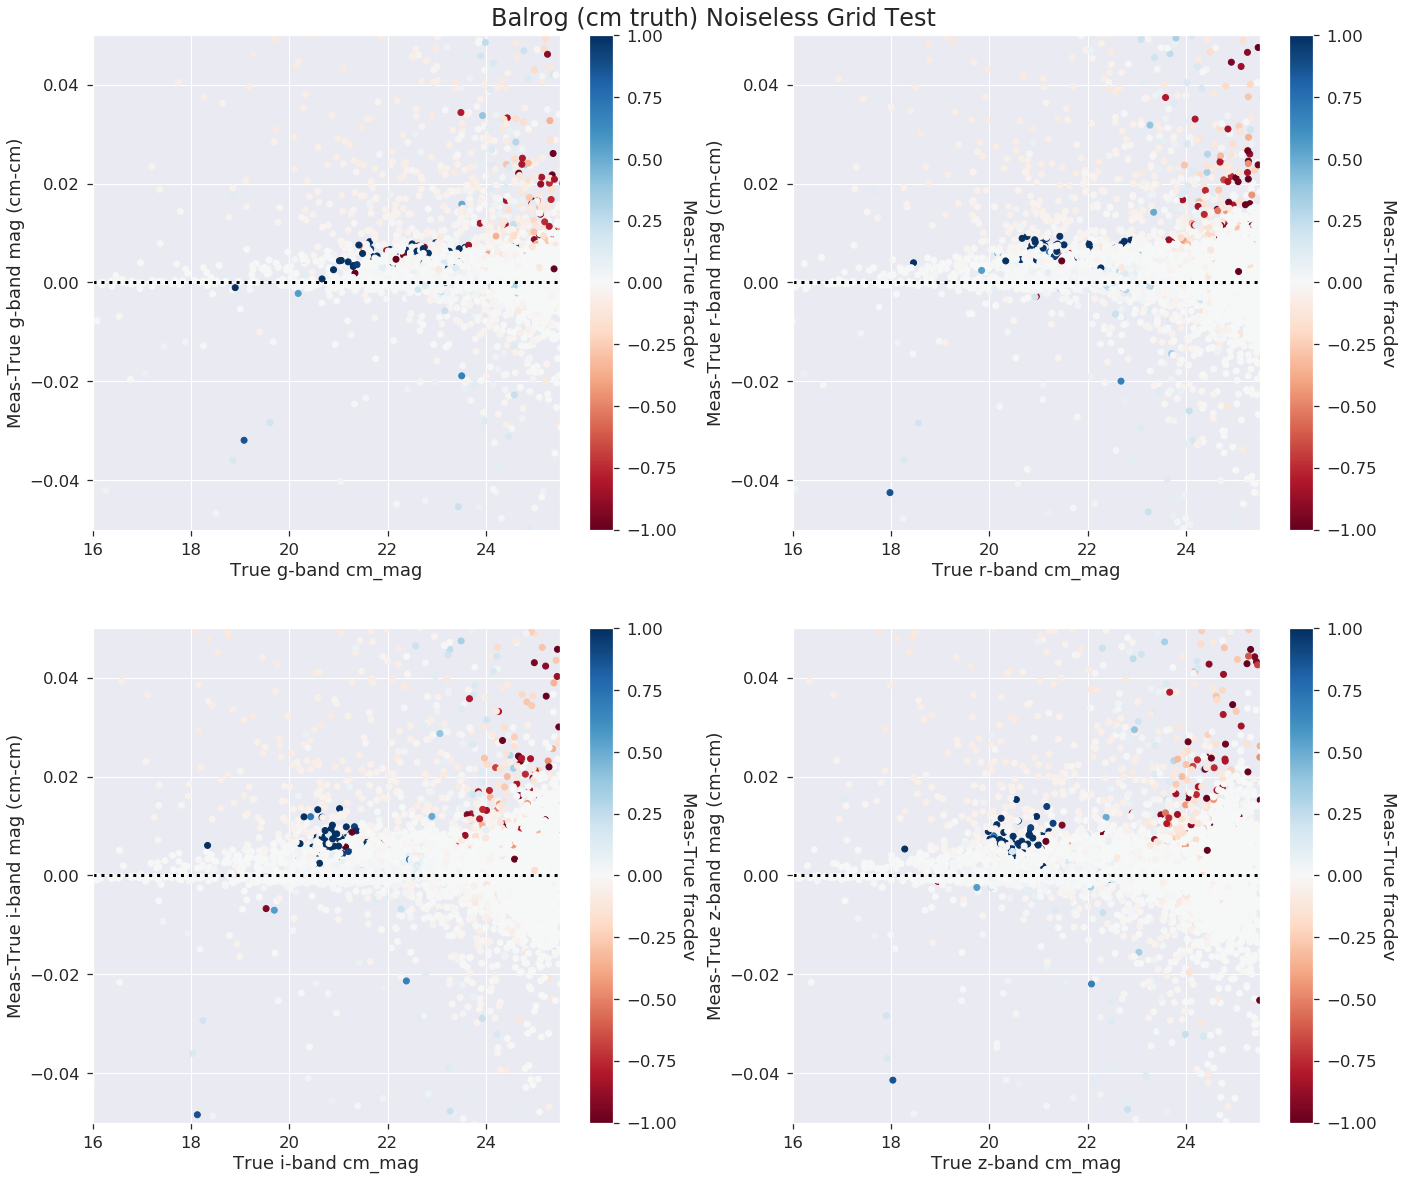

In [99]:
plot_mag_scatter_by_fracdev(sample, true_tag='cm')

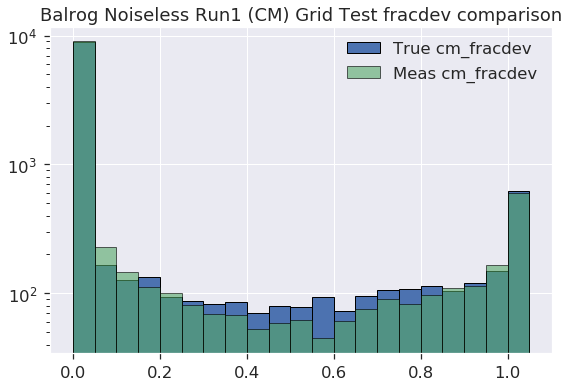

In [100]:
df = 0.05
bins = np.arange(0, 1+2*df, df)
plt.hist(sample['cm_fracdev'], bins=bins, ec='k', label='True cm_fracdev')
plt.hist(sample['meas_cm_fracdev'], bins=bins, ec='k', label='Meas cm_fracdev', alpha=0.6)
plt.legend()
plt.title('Balrog Noiseless Run1 (CM) Grid Test fracdev comparison')
plt.gcf().set_size_inches(9,6)
plt.yscale('log')

# Run1 Noisy Grid Test (CM)

In [79]:
run_name = 'grid-test-cm'
tile = 'DES0347-5540'

In [80]:
true, meas = grab_cats(run_name, tile, true_profile='cm', ext_true_cols=['cm_T', 'cm_fracdev'])

Ntrue: 11619
Nmeas: 9439


In [81]:
sample = match(true, meas)

len before: 11619
len after: 6924


g
r
i
z


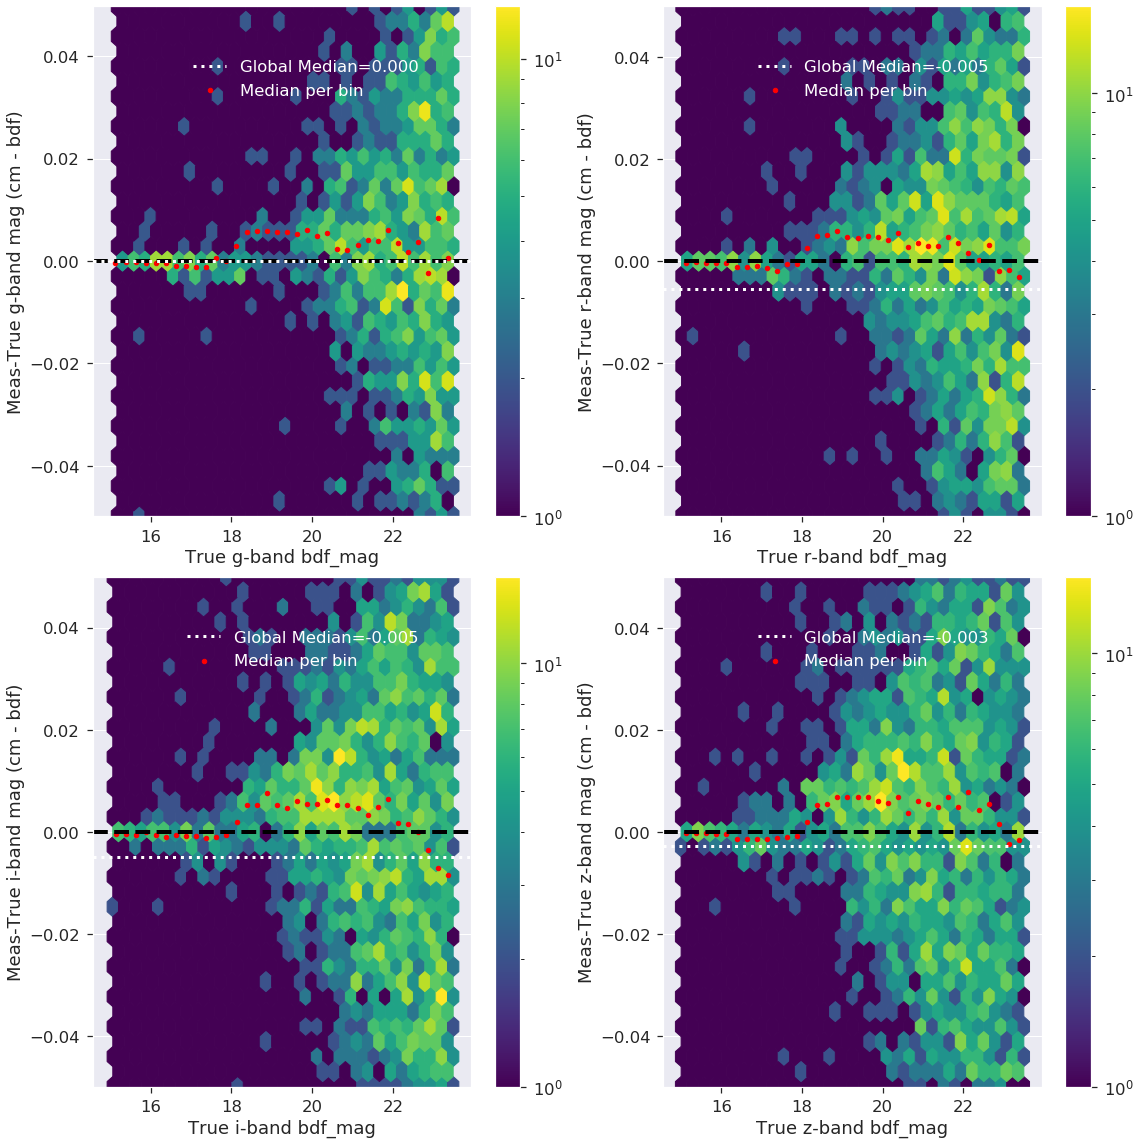

In [82]:
plot_sof_scatter(sample, true_colname='cm_mag_deredden', meas_colname='meas_cm_mag_deredden',
                 xlim=[15, 23.5], ylim=[-.05, .05], gs=30)
# plot_sof_scatter(sample[~ (sample['cm_fracdev'] < 0.95) & (sample['cm_fracdev']>0.01)], true_colname='cm_mag_deredden', meas_colname='meas_cm_mag_deredden',
#                  xlim=[15, 25], ylim=[-.05, .05], gs=40)

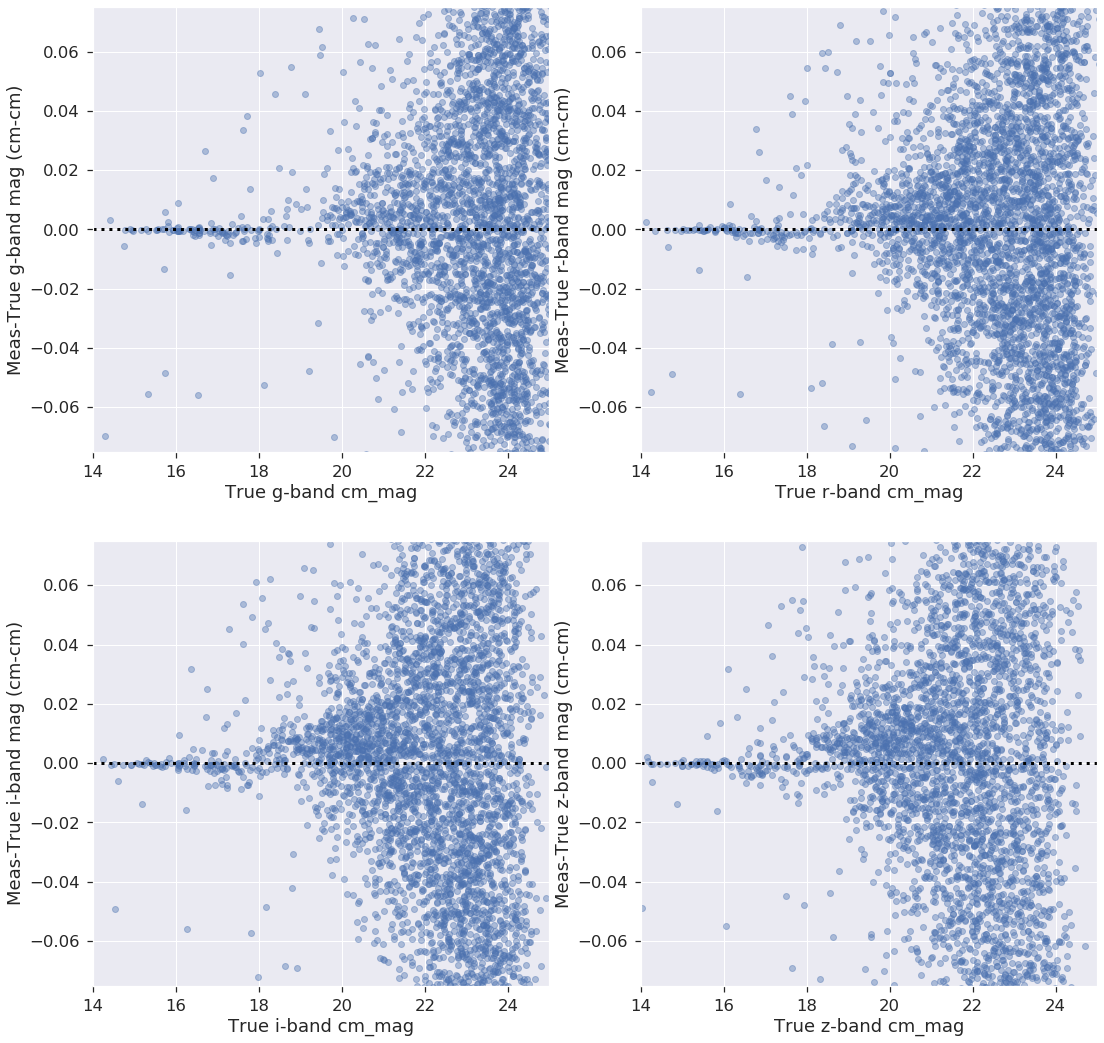

In [83]:
bands = 'griz'
xlim = [14, 25]
ylim = [-0.075, 0.075]
alpha = 0.4
# s = sample[~(sample['cm_fracdev'] < 0.95) & (sample['cm_fracdev']>0.01)]
# s = sample[sample['cm_T'] < 0.1]
s = sample
for bi in range(4):
    plt.subplot(2,2,bi+1)
    x = s['cm_mag_deredden'][:,bi]
    y = s['meas_cm_mag_deredden'][:,bi] - x
    plt.scatter(x, y, alpha=alpha)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.axhline(0, lw=3, ls=':', c='k')
    plt.xlabel('True {}-band cm_mag'.format(bands[bi]))
    plt.ylabel('Meas-True {}-band mag (cm-cm)'.format(bands[bi]))
    
plt.gcf().set_size_inches(18, 18)

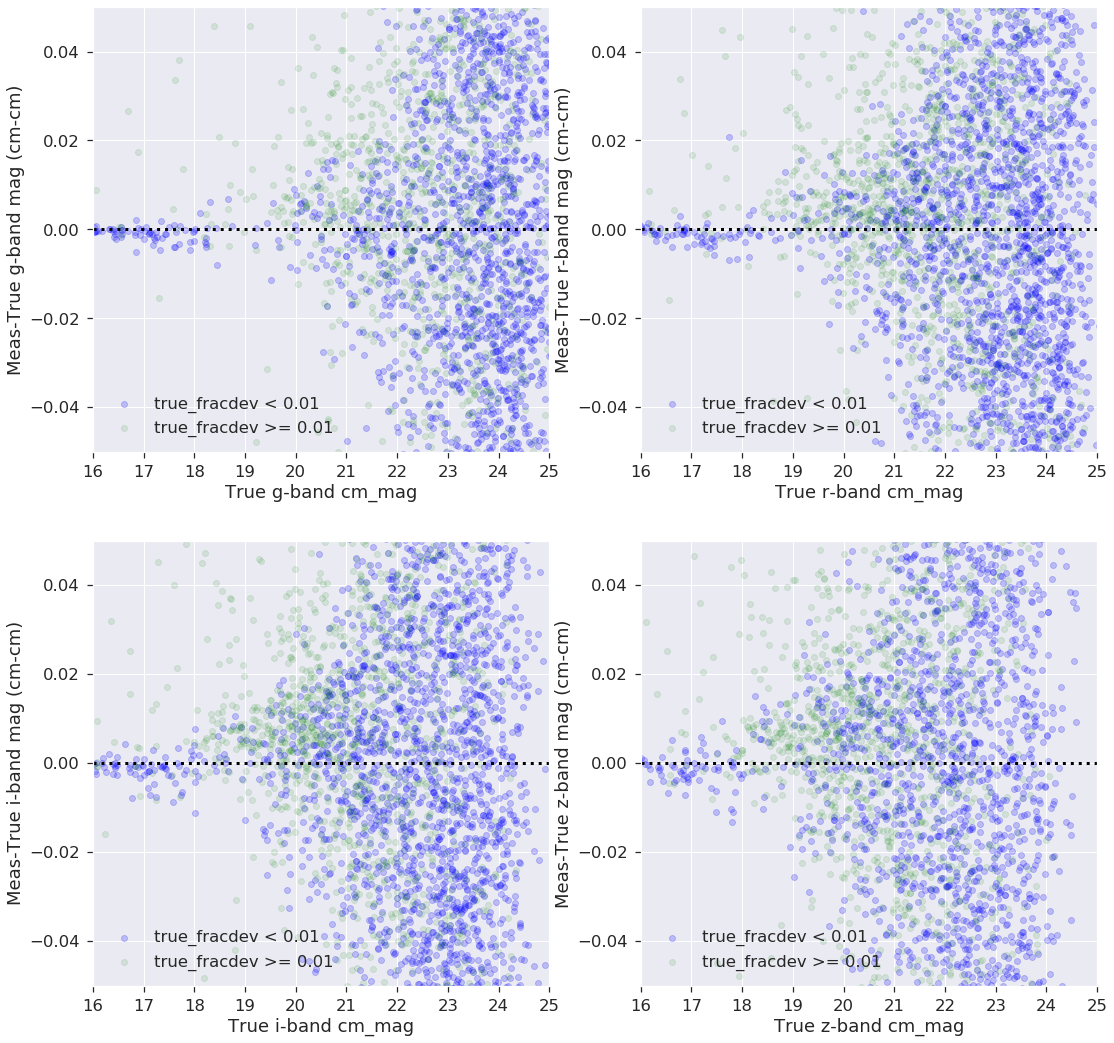

In [84]:
bands = 'griz'
xlim = [16, 25]
ylim = [-0.05, 0.05]
alpha = 0.2
# s = sample[~(sample['cm_fracdev'] < 0.95) & (sample['cm_fracdev']>0.01)]
# s = sample[sample['cm_T'] < 0.1]
s = sample
fd_cut = 0.01
ltcut = np.where(s['cm_fracdev'] < fd_cut)
gtcut = np.where(s['cm_fracdev'] >= fd_cut)
for bi in range(4):
    plt.subplot(2,2,bi+1)
    x = s['cm_mag_deredden'][:,bi]
    y = s['meas_cm_mag_deredden'][:,bi] - x
    plt.scatter(x[ltcut], y[ltcut], alpha=alpha, color='b', label='true_fracdev < {}'.format(fd_cut))
    plt.scatter(x[gtcut], y[gtcut], alpha=0.5*alpha, color='g', label='true_fracdev >= {}'.format(fd_cut))
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.axhline(0, lw=3, ls=':', c='k')
    plt.xlabel('True {}-band cm_mag'.format(bands[bi]))
    plt.ylabel('Meas-True {}-band mag (cm-cm)'.format(bands[bi]))
    plt.legend()
    
plt.gcf().set_size_inches(18, 18)

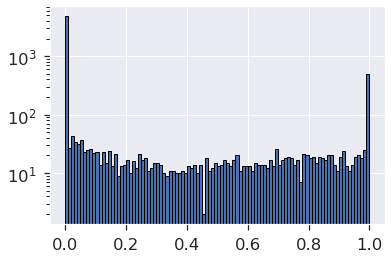

In [85]:
plt.hist(sample['cm_fracdev'], bins=np.arange(0, 1+0.01, 0.01), ec='k')
plt.yscale('log')